# Autoencoders

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

# Loading Data

## DataLoader

In [2]:
class DataLoader:
    
    def load_mnist_data(self):
        """
        Load MNIST dataset.
        """
        print('\nLoading MNIST dataset ...\n')
        mnist = input_data.read_data_sets('MNIST_data', validation_size=0)
        print('\nData loading complete\n')
        return mnist

## ImageDisplayer

In [3]:
class ImageDisplayer:
    
    def show_train_image(self, mnist, img_idx, img_shape, cmap):
        """
        Display a single image in the MNIST training dataset.
        """
        img = mnist.train.images[img_idx]
        plt.imshow(img.reshape(img_shape), cmap=cmap)
        
        
    def show_test_images(self, input_imgs, output_imgs, img_shape, cmap):
        """
        Display first 10 images in the MNIST testing set in original and reconstructed forms. 
        """
        fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
            
        for images, row in zip([input_imgs, output_imgs], axes):
            for img, ax in zip(images, row):
                ax.imshow(img.reshape(image_shape), cmap=cmap)
                ax.get_xaxis().set_visible(False)
                ax.get_yaxis().set_visible(False)

        fig.tight_layout(pad=0.1)

In [4]:
dataLoader = DataLoader()

mnist = dataLoader.load_mnist_data()


Loading MNIST dataset ...

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

Data loading complete



In [5]:
image_shape = (28, 28)
image_size = mnist.train.images.shape[1]
cmap = 'Greys_r'

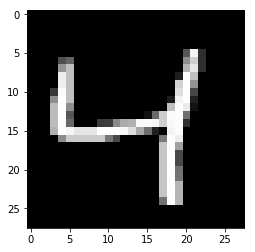

In [6]:
imageDisplayer = ImageDisplayer()

imageDisplayer.show_train_image(mnist, 2, image_shape, cmap)

# Running Simple Autoencoder

## ImageFormatter

In [7]:
class ImageFormatter:
    
    def format_in_imgs(self, imgs, img_shape, reshape, denoising, noise_factor):
        """
        Format input images to feed to network. 
        """
        in_imgs = imgs
        if reshape == True:
            in_imgs = self.reshape_images(in_imgs, img_shape)
        if denoising == True:
            in_imgs = self.add_noise_and_clip_images(in_imgs, noise_factor)
        return in_imgs
    
    
    def format_out_imgs(self, imgs, img_shape, reshape):
        """
        Format output images to feed to network.
        """
        out_imgs = imgs
        if reshape == True:
            out_imgs = self.reshape_images(out_imgs, img_shape)
        return out_imgs
    
        
    def reshape_images(self, imgs, img_shape):
        """
        Reshape input images.
        """
        return imgs.reshape((-1, *img_shape, 1))
    
    
    def add_noise_and_clip_images(self, imgs, noise_factor):
        """
        Add noise to input images and clip them.
        """
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        return noisy_imgs

## ModelRunner

In [8]:
class ModelRunner:
        
    def run_autoencoder(self, 
                        model, 
                        mnist, 
                        img_shape, 
                        epochs, 
                        batch_size, 
                        reshape=False,
                        denoising=False,
                        noise_factor=None):
        """
        Train an autoencoder network model.
        : model: Autoencoder model to train
        : mnist: MNIST dataset
        : img_shape: Image shape
        : epochs: Number of epochs 
        : batch_size: Size of train batch
        : reshape: Whether or not to reshape images
        : denoising: Whether or not the model is for denoising
        : noise_factor: Noise factor to use in case of denoising
        """
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            imageFormatter = ImageFormatter()
            
            print('\nTraining autoencoder ...\n')
            
            # Train the autoencoder
            for e in range(epochs):
                
                for ii in range(mnist.train.num_examples//batch_size):
                    batch = mnist.train.next_batch(batch_size)
                    imgs = batch[0]
                    
                    in_imgs = imageFormatter.format_in_imgs(
                                imgs, img_shape, reshape, 
                                denoising, noise_factor)
                    out_imgs = imageFormatter.format_out_imgs(
                                imgs, img_shape, reshape)
                    
                    feed_dict = {model.inputs: in_imgs, 
                                 model.targets: out_imgs}
                    
                    batch_cost, _ = sess.run([model.cost, model.optimizer], 
                                             feed_dict=feed_dict)
                    
                    print("Epoch: {}/{}...".format(e+1, epochs),
                          "Training loss: {:.4f}".format(batch_cost))
                    
            print('\nTraining complete\n')
            
            print('\nTesting autoencoder with sample images ...\n')
            
            # Test the autoencoder with sample images from the test set
            imgs = mnist.test.images[:10]
            
            in_imgs = imageFormatter.format_in_imgs(
                        imgs, img_shape, reshape, denoising, noise_factor)
            
            feed_dict={model.inputs: in_imgs}
            
            out_imgs = sess.run(model.decoded, 
                                feed_dict=feed_dict)
            
            imageDisplayer.show_test_images(in_imgs, out_imgs, img_shape, cmap)
            
            print('\nTraining and testing complete\n')

## SimpleAutoencoder

In [9]:
class SimpleAutoencoder:

    def build(self, image_size, encoding_dim, learning_rate):
        """
        Build a simple autoencoder with a single RELU hidden layer.
        : image_size: Size of input image
        : encoding_dim: Size of the (hidden) encoding layer
        : learning_rate: Learning rate
        """
        
        print('\nBuilding a simple image autoencoder ...\n')
        
        # Create input and target placeholders
        self.inputs = tf.placeholder(tf.float32, (None, image_size), name='inputs')
        self.targets = tf.placeholder(tf.float32, (None, image_size), name='targets')

        # Output of hidden layer, single fully connected layer here with ReLU activation
        self.encoded = tf.layers.dense(self.inputs, encoding_dim, activation=tf.nn.relu)

        # Output layer logits, fully connected layer with no activation
        logits = tf.layers.dense(self.encoded, image_size, activation=None)
        
        # Sigmoid output from logits
        self.decoded = tf.nn.sigmoid(logits, name='output')
        
        # Sigmoid cross-entropy loss
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.targets, logits=logits)
        # Cost
        self.cost = tf.reduce_mean(loss)
        
        # Optimizer
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        print('Simple image autoencoder built\n')

In [10]:
encoding_dim = 32
learning_rate = 0.001

In [11]:
simpleAutoencoder = SimpleAutoencoder()

simpleAutoencoder.build(image_size, encoding_dim, learning_rate)


Building a simple image autoencoder ...

Simple image autoencoder built



In [12]:
epochs = 20
batch_size = 200


Training autoencoder ...

Epoch: 1/20... Training loss: 0.6933
Epoch: 1/20... Training loss: 0.6903
Epoch: 1/20... Training loss: 0.6867
Epoch: 1/20... Training loss: 0.6829
Epoch: 1/20... Training loss: 0.6782
Epoch: 1/20... Training loss: 0.6724
Epoch: 1/20... Training loss: 0.6652
Epoch: 1/20... Training loss: 0.6568
Epoch: 1/20... Training loss: 0.6455
Epoch: 1/20... Training loss: 0.6342
Epoch: 1/20... Training loss: 0.6218
Epoch: 1/20... Training loss: 0.6081
Epoch: 1/20... Training loss: 0.5932
Epoch: 1/20... Training loss: 0.5765
Epoch: 1/20... Training loss: 0.5579
Epoch: 1/20... Training loss: 0.5406
Epoch: 1/20... Training loss: 0.5222
Epoch: 1/20... Training loss: 0.5019
Epoch: 1/20... Training loss: 0.4848
Epoch: 1/20... Training loss: 0.4679
Epoch: 1/20... Training loss: 0.4500
Epoch: 1/20... Training loss: 0.4356
Epoch: 1/20... Training loss: 0.4160
Epoch: 1/20... Training loss: 0.4074
Epoch: 1/20... Training loss: 0.3944
Epoch: 1/20... Training loss: 0.3749
Epoch: 1/20

Epoch: 1/20... Training loss: 0.1966
Epoch: 1/20... Training loss: 0.1893
Epoch: 1/20... Training loss: 0.2007
Epoch: 1/20... Training loss: 0.1948
Epoch: 1/20... Training loss: 0.1905
Epoch: 1/20... Training loss: 0.1897
Epoch: 1/20... Training loss: 0.2033
Epoch: 1/20... Training loss: 0.1926
Epoch: 1/20... Training loss: 0.1896
Epoch: 1/20... Training loss: 0.1968
Epoch: 1/20... Training loss: 0.1854
Epoch: 1/20... Training loss: 0.1938
Epoch: 1/20... Training loss: 0.1872
Epoch: 1/20... Training loss: 0.1911
Epoch: 1/20... Training loss: 0.1922
Epoch: 1/20... Training loss: 0.1893
Epoch: 1/20... Training loss: 0.1915
Epoch: 1/20... Training loss: 0.1939
Epoch: 1/20... Training loss: 0.1898
Epoch: 1/20... Training loss: 0.1961
Epoch: 1/20... Training loss: 0.1940
Epoch: 1/20... Training loss: 0.1896
Epoch: 1/20... Training loss: 0.1904
Epoch: 1/20... Training loss: 0.1919
Epoch: 1/20... Training loss: 0.1909
Epoch: 1/20... Training loss: 0.1928
Epoch: 1/20... Training loss: 0.1921
E

Epoch: 2/20... Training loss: 0.1592
Epoch: 2/20... Training loss: 0.1590
Epoch: 2/20... Training loss: 0.1615
Epoch: 2/20... Training loss: 0.1591
Epoch: 2/20... Training loss: 0.1605
Epoch: 2/20... Training loss: 0.1607
Epoch: 2/20... Training loss: 0.1614
Epoch: 2/20... Training loss: 0.1556
Epoch: 2/20... Training loss: 0.1583
Epoch: 2/20... Training loss: 0.1591
Epoch: 2/20... Training loss: 0.1594
Epoch: 2/20... Training loss: 0.1572
Epoch: 2/20... Training loss: 0.1612
Epoch: 2/20... Training loss: 0.1563
Epoch: 2/20... Training loss: 0.1597
Epoch: 2/20... Training loss: 0.1594
Epoch: 2/20... Training loss: 0.1576
Epoch: 2/20... Training loss: 0.1551
Epoch: 2/20... Training loss: 0.1574
Epoch: 2/20... Training loss: 0.1627
Epoch: 2/20... Training loss: 0.1607
Epoch: 2/20... Training loss: 0.1570
Epoch: 2/20... Training loss: 0.1567
Epoch: 2/20... Training loss: 0.1574
Epoch: 2/20... Training loss: 0.1645
Epoch: 2/20... Training loss: 0.1577
Epoch: 2/20... Training loss: 0.1521
E

Epoch: 3/20... Training loss: 0.1395
Epoch: 3/20... Training loss: 0.1434
Epoch: 3/20... Training loss: 0.1401
Epoch: 3/20... Training loss: 0.1402
Epoch: 3/20... Training loss: 0.1442
Epoch: 3/20... Training loss: 0.1406
Epoch: 3/20... Training loss: 0.1395
Epoch: 3/20... Training loss: 0.1333
Epoch: 3/20... Training loss: 0.1416
Epoch: 3/20... Training loss: 0.1353
Epoch: 3/20... Training loss: 0.1354
Epoch: 3/20... Training loss: 0.1430
Epoch: 3/20... Training loss: 0.1320
Epoch: 3/20... Training loss: 0.1378
Epoch: 3/20... Training loss: 0.1356
Epoch: 3/20... Training loss: 0.1395
Epoch: 3/20... Training loss: 0.1401
Epoch: 3/20... Training loss: 0.1373
Epoch: 3/20... Training loss: 0.1397
Epoch: 3/20... Training loss: 0.1377
Epoch: 3/20... Training loss: 0.1390
Epoch: 3/20... Training loss: 0.1408
Epoch: 3/20... Training loss: 0.1368
Epoch: 3/20... Training loss: 0.1370
Epoch: 3/20... Training loss: 0.1343
Epoch: 3/20... Training loss: 0.1394
Epoch: 3/20... Training loss: 0.1391
E

Epoch: 4/20... Training loss: 0.1283
Epoch: 4/20... Training loss: 0.1295
Epoch: 4/20... Training loss: 0.1272
Epoch: 4/20... Training loss: 0.1233
Epoch: 4/20... Training loss: 0.1239
Epoch: 4/20... Training loss: 0.1268
Epoch: 4/20... Training loss: 0.1249
Epoch: 4/20... Training loss: 0.1245
Epoch: 4/20... Training loss: 0.1250
Epoch: 4/20... Training loss: 0.1269
Epoch: 4/20... Training loss: 0.1267
Epoch: 4/20... Training loss: 0.1294
Epoch: 4/20... Training loss: 0.1255
Epoch: 4/20... Training loss: 0.1256
Epoch: 4/20... Training loss: 0.1266
Epoch: 4/20... Training loss: 0.1299
Epoch: 4/20... Training loss: 0.1217
Epoch: 4/20... Training loss: 0.1292
Epoch: 4/20... Training loss: 0.1191
Epoch: 4/20... Training loss: 0.1220
Epoch: 4/20... Training loss: 0.1195
Epoch: 4/20... Training loss: 0.1229
Epoch: 4/20... Training loss: 0.1244
Epoch: 4/20... Training loss: 0.1229
Epoch: 4/20... Training loss: 0.1251
Epoch: 4/20... Training loss: 0.1232
Epoch: 4/20... Training loss: 0.1263
E

Epoch: 4/20... Training loss: 0.1163
Epoch: 4/20... Training loss: 0.1183
Epoch: 4/20... Training loss: 0.1172
Epoch: 4/20... Training loss: 0.1137
Epoch: 4/20... Training loss: 0.1172
Epoch: 4/20... Training loss: 0.1179
Epoch: 4/20... Training loss: 0.1201
Epoch: 4/20... Training loss: 0.1144
Epoch: 4/20... Training loss: 0.1170
Epoch: 4/20... Training loss: 0.1174
Epoch: 4/20... Training loss: 0.1180
Epoch: 4/20... Training loss: 0.1211
Epoch: 4/20... Training loss: 0.1154
Epoch: 4/20... Training loss: 0.1197
Epoch: 4/20... Training loss: 0.1108
Epoch: 4/20... Training loss: 0.1143
Epoch: 4/20... Training loss: 0.1180
Epoch: 4/20... Training loss: 0.1172
Epoch: 4/20... Training loss: 0.1139
Epoch: 4/20... Training loss: 0.1158
Epoch: 4/20... Training loss: 0.1142
Epoch: 4/20... Training loss: 0.1148
Epoch: 4/20... Training loss: 0.1138
Epoch: 4/20... Training loss: 0.1196
Epoch: 4/20... Training loss: 0.1202
Epoch: 4/20... Training loss: 0.1162
Epoch: 4/20... Training loss: 0.1196
E

Epoch: 5/20... Training loss: 0.1060
Epoch: 5/20... Training loss: 0.1047
Epoch: 5/20... Training loss: 0.1070
Epoch: 5/20... Training loss: 0.1085
Epoch: 5/20... Training loss: 0.1073
Epoch: 5/20... Training loss: 0.1059
Epoch: 5/20... Training loss: 0.1094
Epoch: 5/20... Training loss: 0.1065
Epoch: 5/20... Training loss: 0.1045
Epoch: 5/20... Training loss: 0.1102
Epoch: 5/20... Training loss: 0.1070
Epoch: 5/20... Training loss: 0.1111
Epoch: 5/20... Training loss: 0.1078
Epoch: 5/20... Training loss: 0.1059
Epoch: 5/20... Training loss: 0.1091
Epoch: 5/20... Training loss: 0.1085
Epoch: 5/20... Training loss: 0.1085
Epoch: 5/20... Training loss: 0.1062
Epoch: 5/20... Training loss: 0.1066
Epoch: 5/20... Training loss: 0.1067
Epoch: 5/20... Training loss: 0.1078
Epoch: 5/20... Training loss: 0.1077
Epoch: 5/20... Training loss: 0.1099
Epoch: 5/20... Training loss: 0.1084
Epoch: 5/20... Training loss: 0.1066
Epoch: 5/20... Training loss: 0.1076
Epoch: 5/20... Training loss: 0.1098
E

Epoch: 6/20... Training loss: 0.1033
Epoch: 6/20... Training loss: 0.1046
Epoch: 6/20... Training loss: 0.0987
Epoch: 6/20... Training loss: 0.1083
Epoch: 6/20... Training loss: 0.1018
Epoch: 6/20... Training loss: 0.1045
Epoch: 6/20... Training loss: 0.1031
Epoch: 6/20... Training loss: 0.1059
Epoch: 6/20... Training loss: 0.1043
Epoch: 6/20... Training loss: 0.1045
Epoch: 6/20... Training loss: 0.1016
Epoch: 6/20... Training loss: 0.1032
Epoch: 6/20... Training loss: 0.1054
Epoch: 6/20... Training loss: 0.1033
Epoch: 6/20... Training loss: 0.1067
Epoch: 6/20... Training loss: 0.1052
Epoch: 6/20... Training loss: 0.1038
Epoch: 6/20... Training loss: 0.1053
Epoch: 6/20... Training loss: 0.1050
Epoch: 6/20... Training loss: 0.1045
Epoch: 6/20... Training loss: 0.1009
Epoch: 6/20... Training loss: 0.1050
Epoch: 6/20... Training loss: 0.1021
Epoch: 6/20... Training loss: 0.1036
Epoch: 6/20... Training loss: 0.1039
Epoch: 6/20... Training loss: 0.1038
Epoch: 6/20... Training loss: 0.1050
E

Epoch: 7/20... Training loss: 0.1017
Epoch: 7/20... Training loss: 0.1023
Epoch: 7/20... Training loss: 0.1038
Epoch: 7/20... Training loss: 0.1054
Epoch: 7/20... Training loss: 0.1007
Epoch: 7/20... Training loss: 0.1015
Epoch: 7/20... Training loss: 0.1002
Epoch: 7/20... Training loss: 0.1014
Epoch: 7/20... Training loss: 0.1037
Epoch: 7/20... Training loss: 0.1016
Epoch: 7/20... Training loss: 0.1027
Epoch: 7/20... Training loss: 0.1077
Epoch: 7/20... Training loss: 0.1066
Epoch: 7/20... Training loss: 0.1000
Epoch: 7/20... Training loss: 0.0978
Epoch: 7/20... Training loss: 0.1014
Epoch: 7/20... Training loss: 0.1023
Epoch: 7/20... Training loss: 0.1024
Epoch: 7/20... Training loss: 0.0983
Epoch: 7/20... Training loss: 0.1022
Epoch: 7/20... Training loss: 0.0994
Epoch: 7/20... Training loss: 0.0991
Epoch: 7/20... Training loss: 0.1041
Epoch: 7/20... Training loss: 0.0971
Epoch: 7/20... Training loss: 0.1003
Epoch: 7/20... Training loss: 0.1031
Epoch: 7/20... Training loss: 0.1029
E

Epoch: 8/20... Training loss: 0.1006
Epoch: 8/20... Training loss: 0.0991
Epoch: 8/20... Training loss: 0.0961
Epoch: 8/20... Training loss: 0.1026
Epoch: 8/20... Training loss: 0.0974
Epoch: 8/20... Training loss: 0.0983
Epoch: 8/20... Training loss: 0.0983
Epoch: 8/20... Training loss: 0.0945
Epoch: 8/20... Training loss: 0.0997
Epoch: 8/20... Training loss: 0.0978
Epoch: 8/20... Training loss: 0.1012
Epoch: 8/20... Training loss: 0.0997
Epoch: 8/20... Training loss: 0.0978
Epoch: 8/20... Training loss: 0.0982
Epoch: 8/20... Training loss: 0.0981
Epoch: 8/20... Training loss: 0.0982
Epoch: 8/20... Training loss: 0.0970
Epoch: 8/20... Training loss: 0.0983
Epoch: 8/20... Training loss: 0.1004
Epoch: 8/20... Training loss: 0.1019
Epoch: 8/20... Training loss: 0.1004
Epoch: 8/20... Training loss: 0.0955
Epoch: 8/20... Training loss: 0.0958
Epoch: 8/20... Training loss: 0.0963
Epoch: 8/20... Training loss: 0.0993
Epoch: 8/20... Training loss: 0.0990
Epoch: 8/20... Training loss: 0.1014
E

Epoch: 8/20... Training loss: 0.0971
Epoch: 8/20... Training loss: 0.0983
Epoch: 8/20... Training loss: 0.0968
Epoch: 8/20... Training loss: 0.0963
Epoch: 8/20... Training loss: 0.1002
Epoch: 8/20... Training loss: 0.0970
Epoch: 8/20... Training loss: 0.0985
Epoch: 8/20... Training loss: 0.0945
Epoch: 8/20... Training loss: 0.0970
Epoch: 8/20... Training loss: 0.0999
Epoch: 8/20... Training loss: 0.0966
Epoch: 8/20... Training loss: 0.0968
Epoch: 8/20... Training loss: 0.0990
Epoch: 8/20... Training loss: 0.0985
Epoch: 8/20... Training loss: 0.0986
Epoch: 8/20... Training loss: 0.1009
Epoch: 8/20... Training loss: 0.0959
Epoch: 8/20... Training loss: 0.0965
Epoch: 8/20... Training loss: 0.0965
Epoch: 8/20... Training loss: 0.0999
Epoch: 8/20... Training loss: 0.0948
Epoch: 8/20... Training loss: 0.0972
Epoch: 8/20... Training loss: 0.0958
Epoch: 8/20... Training loss: 0.0961
Epoch: 8/20... Training loss: 0.0951
Epoch: 8/20... Training loss: 0.0943
Epoch: 8/20... Training loss: 0.0958
E

Epoch: 9/20... Training loss: 0.0959
Epoch: 9/20... Training loss: 0.0952
Epoch: 9/20... Training loss: 0.0958
Epoch: 9/20... Training loss: 0.0944
Epoch: 9/20... Training loss: 0.0963
Epoch: 9/20... Training loss: 0.0976
Epoch: 9/20... Training loss: 0.0972
Epoch: 9/20... Training loss: 0.0935
Epoch: 9/20... Training loss: 0.0963
Epoch: 9/20... Training loss: 0.0963
Epoch: 9/20... Training loss: 0.0974
Epoch: 9/20... Training loss: 0.0971
Epoch: 9/20... Training loss: 0.0985
Epoch: 9/20... Training loss: 0.0988
Epoch: 9/20... Training loss: 0.0971
Epoch: 9/20... Training loss: 0.1020
Epoch: 9/20... Training loss: 0.0937
Epoch: 9/20... Training loss: 0.0995
Epoch: 9/20... Training loss: 0.1004
Epoch: 9/20... Training loss: 0.0977
Epoch: 9/20... Training loss: 0.0962
Epoch: 9/20... Training loss: 0.0906
Epoch: 9/20... Training loss: 0.0923
Epoch: 9/20... Training loss: 0.1006
Epoch: 9/20... Training loss: 0.0962
Epoch: 9/20... Training loss: 0.0960
Epoch: 9/20... Training loss: 0.0982
E

Epoch: 10/20... Training loss: 0.0940
Epoch: 10/20... Training loss: 0.0977
Epoch: 10/20... Training loss: 0.0950
Epoch: 10/20... Training loss: 0.0970
Epoch: 10/20... Training loss: 0.0957
Epoch: 10/20... Training loss: 0.0955
Epoch: 10/20... Training loss: 0.0979
Epoch: 10/20... Training loss: 0.0958
Epoch: 10/20... Training loss: 0.0943
Epoch: 10/20... Training loss: 0.0923
Epoch: 10/20... Training loss: 0.0949
Epoch: 10/20... Training loss: 0.0981
Epoch: 10/20... Training loss: 0.0960
Epoch: 10/20... Training loss: 0.0926
Epoch: 10/20... Training loss: 0.0948
Epoch: 10/20... Training loss: 0.0960
Epoch: 10/20... Training loss: 0.0957
Epoch: 10/20... Training loss: 0.0939
Epoch: 10/20... Training loss: 0.0956
Epoch: 10/20... Training loss: 0.0939
Epoch: 10/20... Training loss: 0.0927
Epoch: 10/20... Training loss: 0.0987
Epoch: 10/20... Training loss: 0.0922
Epoch: 10/20... Training loss: 0.0996
Epoch: 10/20... Training loss: 0.0994
Epoch: 10/20... Training loss: 0.0971
Epoch: 10/20

Epoch: 11/20... Training loss: 0.0958
Epoch: 11/20... Training loss: 0.0950
Epoch: 11/20... Training loss: 0.0946
Epoch: 11/20... Training loss: 0.0942
Epoch: 11/20... Training loss: 0.0979
Epoch: 11/20... Training loss: 0.0983
Epoch: 11/20... Training loss: 0.0957
Epoch: 11/20... Training loss: 0.0934
Epoch: 11/20... Training loss: 0.0976
Epoch: 11/20... Training loss: 0.0983
Epoch: 11/20... Training loss: 0.0947
Epoch: 11/20... Training loss: 0.0935
Epoch: 11/20... Training loss: 0.0955
Epoch: 11/20... Training loss: 0.0951
Epoch: 11/20... Training loss: 0.0944
Epoch: 11/20... Training loss: 0.0957
Epoch: 11/20... Training loss: 0.0961
Epoch: 11/20... Training loss: 0.0976
Epoch: 11/20... Training loss: 0.0962
Epoch: 11/20... Training loss: 0.0929
Epoch: 11/20... Training loss: 0.0936
Epoch: 11/20... Training loss: 0.0929
Epoch: 11/20... Training loss: 0.0927
Epoch: 11/20... Training loss: 0.0959
Epoch: 11/20... Training loss: 0.0945
Epoch: 11/20... Training loss: 0.0961
Epoch: 11/20

Epoch: 11/20... Training loss: 0.0913
Epoch: 11/20... Training loss: 0.0969
Epoch: 11/20... Training loss: 0.0935
Epoch: 11/20... Training loss: 0.0954
Epoch: 11/20... Training loss: 0.0925
Epoch: 11/20... Training loss: 0.0960
Epoch: 11/20... Training loss: 0.0944
Epoch: 11/20... Training loss: 0.0958
Epoch: 11/20... Training loss: 0.0931
Epoch: 11/20... Training loss: 0.0956
Epoch: 11/20... Training loss: 0.0958
Epoch: 11/20... Training loss: 0.0915
Epoch: 11/20... Training loss: 0.0928
Epoch: 11/20... Training loss: 0.0945
Epoch: 11/20... Training loss: 0.0912
Epoch: 11/20... Training loss: 0.0935
Epoch: 11/20... Training loss: 0.0950
Epoch: 11/20... Training loss: 0.0927
Epoch: 11/20... Training loss: 0.1002
Epoch: 11/20... Training loss: 0.0963
Epoch: 11/20... Training loss: 0.0944
Epoch: 11/20... Training loss: 0.0981
Epoch: 11/20... Training loss: 0.0938
Epoch: 11/20... Training loss: 0.0933
Epoch: 11/20... Training loss: 0.0929
Epoch: 11/20... Training loss: 0.0948
Epoch: 11/20

Epoch: 12/20... Training loss: 0.0957
Epoch: 12/20... Training loss: 0.0962
Epoch: 12/20... Training loss: 0.0961
Epoch: 12/20... Training loss: 0.0915
Epoch: 12/20... Training loss: 0.0945
Epoch: 12/20... Training loss: 0.0916
Epoch: 12/20... Training loss: 0.0949
Epoch: 12/20... Training loss: 0.0962
Epoch: 12/20... Training loss: 0.0946
Epoch: 12/20... Training loss: 0.0960
Epoch: 12/20... Training loss: 0.0942
Epoch: 12/20... Training loss: 0.0916
Epoch: 12/20... Training loss: 0.0911
Epoch: 12/20... Training loss: 0.0956
Epoch: 12/20... Training loss: 0.0903
Epoch: 12/20... Training loss: 0.0939
Epoch: 12/20... Training loss: 0.0959
Epoch: 12/20... Training loss: 0.0962
Epoch: 12/20... Training loss: 0.0943
Epoch: 12/20... Training loss: 0.0936
Epoch: 12/20... Training loss: 0.0914
Epoch: 12/20... Training loss: 0.0986
Epoch: 12/20... Training loss: 0.0973
Epoch: 12/20... Training loss: 0.0931
Epoch: 12/20... Training loss: 0.0978
Epoch: 12/20... Training loss: 0.0947
Epoch: 12/20

Epoch: 13/20... Training loss: 0.0934
Epoch: 13/20... Training loss: 0.0957
Epoch: 13/20... Training loss: 0.0947
Epoch: 13/20... Training loss: 0.0953
Epoch: 13/20... Training loss: 0.0942
Epoch: 13/20... Training loss: 0.0948
Epoch: 13/20... Training loss: 0.0928
Epoch: 13/20... Training loss: 0.0958
Epoch: 13/20... Training loss: 0.0905
Epoch: 13/20... Training loss: 0.0961
Epoch: 13/20... Training loss: 0.0958
Epoch: 13/20... Training loss: 0.0914
Epoch: 13/20... Training loss: 0.0997
Epoch: 13/20... Training loss: 0.0943
Epoch: 13/20... Training loss: 0.0957
Epoch: 13/20... Training loss: 0.0935
Epoch: 13/20... Training loss: 0.0910
Epoch: 13/20... Training loss: 0.0935
Epoch: 13/20... Training loss: 0.0963
Epoch: 13/20... Training loss: 0.0973
Epoch: 13/20... Training loss: 0.0922
Epoch: 13/20... Training loss: 0.0922
Epoch: 13/20... Training loss: 0.0963
Epoch: 13/20... Training loss: 0.0964
Epoch: 13/20... Training loss: 0.0930
Epoch: 13/20... Training loss: 0.0946
Epoch: 13/20

Epoch: 14/20... Training loss: 0.0954
Epoch: 14/20... Training loss: 0.0947
Epoch: 14/20... Training loss: 0.0922
Epoch: 14/20... Training loss: 0.0936
Epoch: 14/20... Training loss: 0.0969
Epoch: 14/20... Training loss: 0.0902
Epoch: 14/20... Training loss: 0.0961
Epoch: 14/20... Training loss: 0.0928
Epoch: 14/20... Training loss: 0.0947
Epoch: 14/20... Training loss: 0.0910
Epoch: 14/20... Training loss: 0.0934
Epoch: 14/20... Training loss: 0.0983
Epoch: 14/20... Training loss: 0.0935
Epoch: 14/20... Training loss: 0.0929
Epoch: 14/20... Training loss: 0.0966
Epoch: 14/20... Training loss: 0.0952
Epoch: 14/20... Training loss: 0.0936
Epoch: 14/20... Training loss: 0.0920
Epoch: 14/20... Training loss: 0.0956
Epoch: 14/20... Training loss: 0.0970
Epoch: 14/20... Training loss: 0.0947
Epoch: 14/20... Training loss: 0.0987
Epoch: 14/20... Training loss: 0.0914
Epoch: 14/20... Training loss: 0.0919
Epoch: 14/20... Training loss: 0.0948
Epoch: 14/20... Training loss: 0.1000
Epoch: 14/20

Epoch: 14/20... Training loss: 0.0961
Epoch: 14/20... Training loss: 0.0946
Epoch: 14/20... Training loss: 0.0942
Epoch: 14/20... Training loss: 0.0953
Epoch: 14/20... Training loss: 0.0931
Epoch: 14/20... Training loss: 0.0902
Epoch: 14/20... Training loss: 0.0941
Epoch: 14/20... Training loss: 0.0936
Epoch: 14/20... Training loss: 0.0933
Epoch: 14/20... Training loss: 0.0958
Epoch: 14/20... Training loss: 0.0922
Epoch: 14/20... Training loss: 0.0908
Epoch: 14/20... Training loss: 0.0973
Epoch: 14/20... Training loss: 0.0956
Epoch: 14/20... Training loss: 0.0935
Epoch: 14/20... Training loss: 0.0919
Epoch: 14/20... Training loss: 0.0941
Epoch: 14/20... Training loss: 0.0940
Epoch: 14/20... Training loss: 0.0937
Epoch: 14/20... Training loss: 0.0921
Epoch: 14/20... Training loss: 0.0944
Epoch: 14/20... Training loss: 0.0905
Epoch: 14/20... Training loss: 0.0966
Epoch: 14/20... Training loss: 0.0934
Epoch: 14/20... Training loss: 0.0939
Epoch: 14/20... Training loss: 0.0957
Epoch: 14/20

Epoch: 15/20... Training loss: 0.0930
Epoch: 15/20... Training loss: 0.0972
Epoch: 15/20... Training loss: 0.0941
Epoch: 15/20... Training loss: 0.0958
Epoch: 15/20... Training loss: 0.0948
Epoch: 15/20... Training loss: 0.0986
Epoch: 15/20... Training loss: 0.0967
Epoch: 15/20... Training loss: 0.0917
Epoch: 15/20... Training loss: 0.0954
Epoch: 15/20... Training loss: 0.0906
Epoch: 15/20... Training loss: 0.0949
Epoch: 15/20... Training loss: 0.0915
Epoch: 15/20... Training loss: 0.0907
Epoch: 15/20... Training loss: 0.0926
Epoch: 15/20... Training loss: 0.0956
Epoch: 15/20... Training loss: 0.0920
Epoch: 15/20... Training loss: 0.0935
Epoch: 15/20... Training loss: 0.0942
Epoch: 15/20... Training loss: 0.0950
Epoch: 15/20... Training loss: 0.0938
Epoch: 15/20... Training loss: 0.0956
Epoch: 15/20... Training loss: 0.0943
Epoch: 15/20... Training loss: 0.0927
Epoch: 15/20... Training loss: 0.0931
Epoch: 15/20... Training loss: 0.0936
Epoch: 15/20... Training loss: 0.0968
Epoch: 15/20

Epoch: 16/20... Training loss: 0.0942
Epoch: 16/20... Training loss: 0.0953
Epoch: 16/20... Training loss: 0.0939
Epoch: 16/20... Training loss: 0.0939
Epoch: 16/20... Training loss: 0.0943
Epoch: 16/20... Training loss: 0.0960
Epoch: 16/20... Training loss: 0.0928
Epoch: 16/20... Training loss: 0.0938
Epoch: 16/20... Training loss: 0.0962
Epoch: 16/20... Training loss: 0.0963
Epoch: 16/20... Training loss: 0.0941
Epoch: 16/20... Training loss: 0.0959
Epoch: 16/20... Training loss: 0.0916
Epoch: 16/20... Training loss: 0.0954
Epoch: 16/20... Training loss: 0.0953
Epoch: 16/20... Training loss: 0.0914
Epoch: 16/20... Training loss: 0.0931
Epoch: 16/20... Training loss: 0.0924
Epoch: 16/20... Training loss: 0.0964
Epoch: 16/20... Training loss: 0.0922
Epoch: 16/20... Training loss: 0.0930
Epoch: 16/20... Training loss: 0.0909
Epoch: 16/20... Training loss: 0.0914
Epoch: 16/20... Training loss: 0.0945
Epoch: 16/20... Training loss: 0.0903
Epoch: 16/20... Training loss: 0.0917
Epoch: 16/20

Epoch: 17/20... Training loss: 0.0929
Epoch: 17/20... Training loss: 0.0903
Epoch: 17/20... Training loss: 0.0925
Epoch: 17/20... Training loss: 0.0951
Epoch: 17/20... Training loss: 0.0928
Epoch: 17/20... Training loss: 0.0943
Epoch: 17/20... Training loss: 0.0915
Epoch: 17/20... Training loss: 0.0921
Epoch: 17/20... Training loss: 0.0925
Epoch: 17/20... Training loss: 0.0916
Epoch: 17/20... Training loss: 0.0958
Epoch: 17/20... Training loss: 0.0938
Epoch: 17/20... Training loss: 0.0910
Epoch: 17/20... Training loss: 0.0952
Epoch: 17/20... Training loss: 0.0965
Epoch: 17/20... Training loss: 0.0940
Epoch: 17/20... Training loss: 0.0943
Epoch: 17/20... Training loss: 0.0952
Epoch: 17/20... Training loss: 0.0942
Epoch: 17/20... Training loss: 0.0938
Epoch: 17/20... Training loss: 0.0927
Epoch: 17/20... Training loss: 0.0919
Epoch: 17/20... Training loss: 0.0947
Epoch: 17/20... Training loss: 0.0931
Epoch: 17/20... Training loss: 0.0929
Epoch: 17/20... Training loss: 0.0900
Epoch: 17/20

Epoch: 17/20... Training loss: 0.0941
Epoch: 17/20... Training loss: 0.0895
Epoch: 17/20... Training loss: 0.0922
Epoch: 17/20... Training loss: 0.0964
Epoch: 17/20... Training loss: 0.0941
Epoch: 17/20... Training loss: 0.0926
Epoch: 17/20... Training loss: 0.0947
Epoch: 17/20... Training loss: 0.0933
Epoch: 17/20... Training loss: 0.0947
Epoch: 17/20... Training loss: 0.0976
Epoch: 17/20... Training loss: 0.0935
Epoch: 17/20... Training loss: 0.0935
Epoch: 17/20... Training loss: 0.0934
Epoch: 17/20... Training loss: 0.0980
Epoch: 17/20... Training loss: 0.0937
Epoch: 17/20... Training loss: 0.0935
Epoch: 17/20... Training loss: 0.0941
Epoch: 17/20... Training loss: 0.0929
Epoch: 17/20... Training loss: 0.0913
Epoch: 17/20... Training loss: 0.0945
Epoch: 17/20... Training loss: 0.0909
Epoch: 17/20... Training loss: 0.0913
Epoch: 17/20... Training loss: 0.0972
Epoch: 17/20... Training loss: 0.0919
Epoch: 17/20... Training loss: 0.0952
Epoch: 17/20... Training loss: 0.0958
Epoch: 17/20

Epoch: 18/20... Training loss: 0.0942
Epoch: 18/20... Training loss: 0.0926
Epoch: 18/20... Training loss: 0.0881
Epoch: 18/20... Training loss: 0.0949
Epoch: 18/20... Training loss: 0.0917
Epoch: 18/20... Training loss: 0.0898
Epoch: 18/20... Training loss: 0.0968
Epoch: 18/20... Training loss: 0.0903
Epoch: 18/20... Training loss: 0.0928
Epoch: 18/20... Training loss: 0.0937
Epoch: 18/20... Training loss: 0.0960
Epoch: 18/20... Training loss: 0.0931
Epoch: 18/20... Training loss: 0.0917
Epoch: 18/20... Training loss: 0.0945
Epoch: 18/20... Training loss: 0.0933
Epoch: 18/20... Training loss: 0.0971
Epoch: 18/20... Training loss: 0.0960
Epoch: 18/20... Training loss: 0.0951
Epoch: 18/20... Training loss: 0.0902
Epoch: 18/20... Training loss: 0.0965
Epoch: 18/20... Training loss: 0.0897
Epoch: 18/20... Training loss: 0.0923
Epoch: 18/20... Training loss: 0.0927
Epoch: 18/20... Training loss: 0.0899
Epoch: 18/20... Training loss: 0.0943
Epoch: 18/20... Training loss: 0.0904
Epoch: 18/20

Epoch: 19/20... Training loss: 0.0952
Epoch: 19/20... Training loss: 0.0916
Epoch: 19/20... Training loss: 0.0910
Epoch: 19/20... Training loss: 0.0912
Epoch: 19/20... Training loss: 0.0930
Epoch: 19/20... Training loss: 0.0919
Epoch: 19/20... Training loss: 0.0916
Epoch: 19/20... Training loss: 0.0935
Epoch: 19/20... Training loss: 0.0937
Epoch: 19/20... Training loss: 0.0929
Epoch: 19/20... Training loss: 0.0927
Epoch: 19/20... Training loss: 0.0932
Epoch: 19/20... Training loss: 0.0968
Epoch: 19/20... Training loss: 0.0949
Epoch: 19/20... Training loss: 0.0920
Epoch: 19/20... Training loss: 0.0931
Epoch: 19/20... Training loss: 0.0954
Epoch: 19/20... Training loss: 0.0934
Epoch: 19/20... Training loss: 0.0914
Epoch: 19/20... Training loss: 0.0912
Epoch: 19/20... Training loss: 0.0904
Epoch: 19/20... Training loss: 0.0922
Epoch: 19/20... Training loss: 0.0926
Epoch: 19/20... Training loss: 0.0923
Epoch: 19/20... Training loss: 0.0926
Epoch: 19/20... Training loss: 0.0915
Epoch: 19/20

Epoch: 20/20... Training loss: 0.0928
Epoch: 20/20... Training loss: 0.0930
Epoch: 20/20... Training loss: 0.0936
Epoch: 20/20... Training loss: 0.0906
Epoch: 20/20... Training loss: 0.0915
Epoch: 20/20... Training loss: 0.0939
Epoch: 20/20... Training loss: 0.0921
Epoch: 20/20... Training loss: 0.0909
Epoch: 20/20... Training loss: 0.0924
Epoch: 20/20... Training loss: 0.0909
Epoch: 20/20... Training loss: 0.0931
Epoch: 20/20... Training loss: 0.0951
Epoch: 20/20... Training loss: 0.0916
Epoch: 20/20... Training loss: 0.0906
Epoch: 20/20... Training loss: 0.0974
Epoch: 20/20... Training loss: 0.0920
Epoch: 20/20... Training loss: 0.0938
Epoch: 20/20... Training loss: 0.0939
Epoch: 20/20... Training loss: 0.0935
Epoch: 20/20... Training loss: 0.0959
Epoch: 20/20... Training loss: 0.0918
Epoch: 20/20... Training loss: 0.0897
Epoch: 20/20... Training loss: 0.0900
Epoch: 20/20... Training loss: 0.0960
Epoch: 20/20... Training loss: 0.0914
Epoch: 20/20... Training loss: 0.0917
Epoch: 20/20

Epoch: 20/20... Training loss: 0.0954
Epoch: 20/20... Training loss: 0.0960
Epoch: 20/20... Training loss: 0.0931
Epoch: 20/20... Training loss: 0.0956
Epoch: 20/20... Training loss: 0.0951
Epoch: 20/20... Training loss: 0.0925
Epoch: 20/20... Training loss: 0.0909
Epoch: 20/20... Training loss: 0.0928
Epoch: 20/20... Training loss: 0.0947
Epoch: 20/20... Training loss: 0.0875
Epoch: 20/20... Training loss: 0.0960
Epoch: 20/20... Training loss: 0.0927
Epoch: 20/20... Training loss: 0.0927
Epoch: 20/20... Training loss: 0.0980
Epoch: 20/20... Training loss: 0.0938
Epoch: 20/20... Training loss: 0.0935
Epoch: 20/20... Training loss: 0.0929
Epoch: 20/20... Training loss: 0.0901
Epoch: 20/20... Training loss: 0.0924
Epoch: 20/20... Training loss: 0.0946
Epoch: 20/20... Training loss: 0.0962
Epoch: 20/20... Training loss: 0.0967
Epoch: 20/20... Training loss: 0.0956
Epoch: 20/20... Training loss: 0.0907
Epoch: 20/20... Training loss: 0.0915
Epoch: 20/20... Training loss: 0.0939
Epoch: 20/20

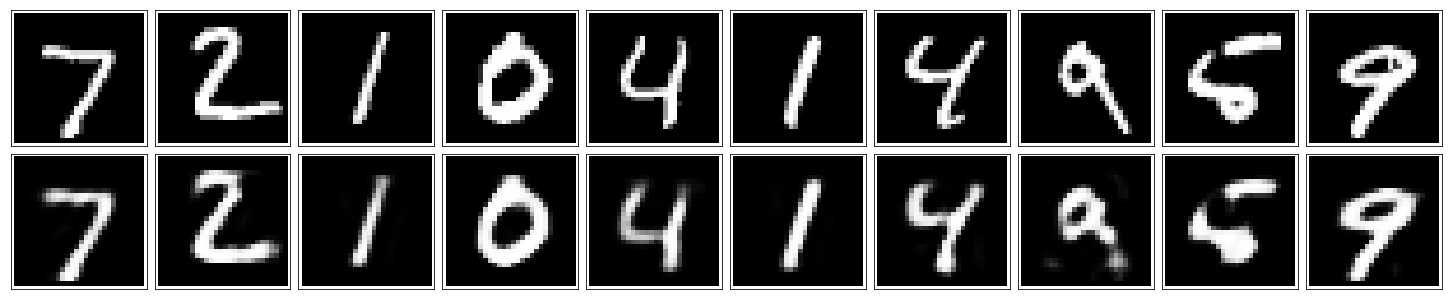

In [13]:
modelRunner = ModelRunner()

modelRunner.run_autoencoder(simpleAutoencoder, mnist, image_shape, epochs, batch_size)

# Running Convolutional Autoencoder

## ConvolutionalAutoencoder

In [14]:
class ConvolutionalAutoencoder:
    
    def build(self, image_shape, learning_rate, conv_outputs=(None,16,8,8,8,8,16)):
        """
        Build an image autoencoder using convolution.
        : image_shape: Image shape
        : learning_rate: Learning rate
        """
        
        print('\nBuilding a convolutional autoencoder ...\n')
        
        ##### Placeholders
        # 28x28x1 input
        self.inputs = tf.placeholder(tf.float32, (None, *image_shape, 1), name='inputs')
        self.targets = tf.placeholder(tf.float32, (None, *image_shape, 1), name='targets')
        
        ##### Encoder
        # 4x4x8 encoder output
        encoder_logits = self.build_encoder(self.inputs, conv_outputs)
        self.encoded = tf.identity(encoder_logits, name='encoded')
        
        ##### Decoder
        # 28x28x1 decoder output
        decoder_logits = self.build_decoder(encoder_logits, conv_outputs)
        self.decoded = tf.nn.sigmoid(decoder_logits, name='decoded')

        ##### Cost and Optimizer
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=self.targets, logits=decoder_logits)
        self.cost = tf.reduce_mean(loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        print('Convolutional autoencoder built\n')
    
    def build_encoder(self, _input, conv_outputs):
        # 28x28x16 (or 28x28x32) convolution
        conv1 = self.conv2d(_input, conv_outputs[1])
        # 14x14x16 (or 14x14x32) maxpool
        maxpool1 = self.maxpool2d(conv1)
        
        # 14x14x8 (or 14x14x32) convolution
        conv2 = self.conv2d(maxpool1, conv_outputs[2])
        # 7x7x8 (or 7x7x32) maxpool
        maxpool2 = self.maxpool2d(conv2)
        
        # 7x7x8 (or 7x7x16) convolution
        conv3 = self.conv2d(maxpool2, conv_outputs[3])
        # 4x4x8 (or 4x4x16) maxpool
        maxpool3 = self.maxpool2d(conv3)
        
        return maxpool3
    
    def build_decoder(self, _input, conv_outputs):
        upsample_sizes = (None, (7,7), (14,14), (28,28))
        
        # 7x7x8 (or 7x7x16) upsample
        upsample1 = self.upsample(_input, (7,7))
        # 7x7x8 (or 7x7x16) convolution
        conv4 = self.conv2d(upsample1, conv_outputs[4])
        
        # 14x14x8 (or 14x14x32) upsample
        upsample2 = self.upsample(conv4, (14,14))
        # 14x14x8 (or 14x14x32) convolution
        conv5 = self.conv2d(upsample2, conv_outputs[5])
        
        # 28x28x8 (or 28x28x32) upsample
        upsample3 = self.upsample(conv5, (28,28))
        # 28x28x16 (or 28x28x32) convolution
        conv6 = self.conv2d(upsample3, conv_outputs[6])
        
        # 28x28x1 output
        logits = self.conv2d(conv6, 1, None)
        
        return logits
    
    
    def conv2d(self, x, num_outputs, activation=tf.nn.relu):
        return tf.layers.conv2d(x, 
                                num_outputs, 
                                (3,3), # kernels 
                                padding='same', 
                                activation=activation)
    
    def maxpool2d(self, x):
        return tf.layers.max_pooling2d(x, 
                                       (2,2), # kernels
                                       (2,2), # strides
                                       padding='same')

    def upsample(self, x, size):
        return tf.image.resize_nearest_neighbor(x, size)

In [15]:
conv_outputs = (None,16,8,8,8,8,16)

In [16]:
convAutoencoder = ConvolutionalAutoencoder()

convAutoencoder.build(image_shape, learning_rate, conv_outputs)


Building a convolutional autoencoder ...

Convolutional autoencoder built




Training autoencoder ...

Epoch: 1/20... Training loss: 0.7078
Epoch: 1/20... Training loss: 0.7003
Epoch: 1/20... Training loss: 0.6944
Epoch: 1/20... Training loss: 0.6894
Epoch: 1/20... Training loss: 0.6848
Epoch: 1/20... Training loss: 0.6807
Epoch: 1/20... Training loss: 0.6763
Epoch: 1/20... Training loss: 0.6712
Epoch: 1/20... Training loss: 0.6654
Epoch: 1/20... Training loss: 0.6600
Epoch: 1/20... Training loss: 0.6523
Epoch: 1/20... Training loss: 0.6435
Epoch: 1/20... Training loss: 0.6354
Epoch: 1/20... Training loss: 0.6230
Epoch: 1/20... Training loss: 0.6110
Epoch: 1/20... Training loss: 0.5950
Epoch: 1/20... Training loss: 0.5822
Epoch: 1/20... Training loss: 0.5649
Epoch: 1/20... Training loss: 0.5454
Epoch: 1/20... Training loss: 0.5330
Epoch: 1/20... Training loss: 0.5269
Epoch: 1/20... Training loss: 0.5109
Epoch: 1/20... Training loss: 0.5182
Epoch: 1/20... Training loss: 0.5062
Epoch: 1/20... Training loss: 0.5061
Epoch: 1/20... Training loss: 0.5074
Epoch: 1/20

Epoch: 1/20... Training loss: 0.1749
Epoch: 1/20... Training loss: 0.1681
Epoch: 1/20... Training loss: 0.1662
Epoch: 1/20... Training loss: 0.1647
Epoch: 1/20... Training loss: 0.1720
Epoch: 1/20... Training loss: 0.1704
Epoch: 1/20... Training loss: 0.1667
Epoch: 1/20... Training loss: 0.1691
Epoch: 1/20... Training loss: 0.1662
Epoch: 1/20... Training loss: 0.1662
Epoch: 1/20... Training loss: 0.1675
Epoch: 1/20... Training loss: 0.1744
Epoch: 1/20... Training loss: 0.1669
Epoch: 1/20... Training loss: 0.1676
Epoch: 1/20... Training loss: 0.1623
Epoch: 1/20... Training loss: 0.1656
Epoch: 1/20... Training loss: 0.1638
Epoch: 1/20... Training loss: 0.1673
Epoch: 1/20... Training loss: 0.1694
Epoch: 1/20... Training loss: 0.1616
Epoch: 1/20... Training loss: 0.1690
Epoch: 1/20... Training loss: 0.1603
Epoch: 1/20... Training loss: 0.1684
Epoch: 1/20... Training loss: 0.1682
Epoch: 1/20... Training loss: 0.1593
Epoch: 1/20... Training loss: 0.1657
Epoch: 1/20... Training loss: 0.1658
E

Epoch: 2/20... Training loss: 0.1430
Epoch: 2/20... Training loss: 0.1439
Epoch: 2/20... Training loss: 0.1362
Epoch: 2/20... Training loss: 0.1420
Epoch: 2/20... Training loss: 0.1396
Epoch: 2/20... Training loss: 0.1414
Epoch: 2/20... Training loss: 0.1353
Epoch: 2/20... Training loss: 0.1486
Epoch: 2/20... Training loss: 0.1334
Epoch: 2/20... Training loss: 0.1424
Epoch: 2/20... Training loss: 0.1357
Epoch: 2/20... Training loss: 0.1353
Epoch: 2/20... Training loss: 0.1381
Epoch: 2/20... Training loss: 0.1417
Epoch: 2/20... Training loss: 0.1400
Epoch: 2/20... Training loss: 0.1407
Epoch: 2/20... Training loss: 0.1411
Epoch: 2/20... Training loss: 0.1433
Epoch: 2/20... Training loss: 0.1365
Epoch: 2/20... Training loss: 0.1388
Epoch: 2/20... Training loss: 0.1436
Epoch: 2/20... Training loss: 0.1386
Epoch: 2/20... Training loss: 0.1302
Epoch: 2/20... Training loss: 0.1422
Epoch: 2/20... Training loss: 0.1392
Epoch: 2/20... Training loss: 0.1373
Epoch: 2/20... Training loss: 0.1438
E

Epoch: 3/20... Training loss: 0.1299
Epoch: 3/20... Training loss: 0.1309
Epoch: 3/20... Training loss: 0.1319
Epoch: 3/20... Training loss: 0.1295
Epoch: 3/20... Training loss: 0.1324
Epoch: 3/20... Training loss: 0.1321
Epoch: 3/20... Training loss: 0.1320
Epoch: 3/20... Training loss: 0.1297
Epoch: 3/20... Training loss: 0.1339
Epoch: 3/20... Training loss: 0.1274
Epoch: 3/20... Training loss: 0.1307
Epoch: 3/20... Training loss: 0.1250
Epoch: 3/20... Training loss: 0.1279
Epoch: 3/20... Training loss: 0.1241
Epoch: 3/20... Training loss: 0.1215
Epoch: 3/20... Training loss: 0.1333
Epoch: 3/20... Training loss: 0.1315
Epoch: 3/20... Training loss: 0.1355
Epoch: 3/20... Training loss: 0.1264
Epoch: 3/20... Training loss: 0.1239
Epoch: 3/20... Training loss: 0.1273
Epoch: 3/20... Training loss: 0.1263
Epoch: 3/20... Training loss: 0.1298
Epoch: 3/20... Training loss: 0.1316
Epoch: 3/20... Training loss: 0.1302
Epoch: 3/20... Training loss: 0.1290
Epoch: 3/20... Training loss: 0.1273
E

Epoch: 4/20... Training loss: 0.1161
Epoch: 4/20... Training loss: 0.1233
Epoch: 4/20... Training loss: 0.1220
Epoch: 4/20... Training loss: 0.1199
Epoch: 4/20... Training loss: 0.1248
Epoch: 4/20... Training loss: 0.1237
Epoch: 4/20... Training loss: 0.1240
Epoch: 4/20... Training loss: 0.1218
Epoch: 4/20... Training loss: 0.1208
Epoch: 4/20... Training loss: 0.1233
Epoch: 4/20... Training loss: 0.1235
Epoch: 4/20... Training loss: 0.1213
Epoch: 4/20... Training loss: 0.1175
Epoch: 4/20... Training loss: 0.1247
Epoch: 4/20... Training loss: 0.1243
Epoch: 4/20... Training loss: 0.1242
Epoch: 4/20... Training loss: 0.1240
Epoch: 4/20... Training loss: 0.1190
Epoch: 4/20... Training loss: 0.1249
Epoch: 4/20... Training loss: 0.1196
Epoch: 4/20... Training loss: 0.1168
Epoch: 4/20... Training loss: 0.1245
Epoch: 4/20... Training loss: 0.1269
Epoch: 4/20... Training loss: 0.1252
Epoch: 4/20... Training loss: 0.1203
Epoch: 4/20... Training loss: 0.1211
Epoch: 4/20... Training loss: 0.1278
E

Epoch: 4/20... Training loss: 0.1185
Epoch: 4/20... Training loss: 0.1161
Epoch: 4/20... Training loss: 0.1185
Epoch: 4/20... Training loss: 0.1193
Epoch: 4/20... Training loss: 0.1190
Epoch: 4/20... Training loss: 0.1195
Epoch: 4/20... Training loss: 0.1176
Epoch: 4/20... Training loss: 0.1174
Epoch: 4/20... Training loss: 0.1195
Epoch: 4/20... Training loss: 0.1154
Epoch: 4/20... Training loss: 0.1148
Epoch: 4/20... Training loss: 0.1144
Epoch: 4/20... Training loss: 0.1129
Epoch: 4/20... Training loss: 0.1176
Epoch: 4/20... Training loss: 0.1178
Epoch: 4/20... Training loss: 0.1205
Epoch: 4/20... Training loss: 0.1158
Epoch: 4/20... Training loss: 0.1167
Epoch: 4/20... Training loss: 0.1174
Epoch: 4/20... Training loss: 0.1186
Epoch: 4/20... Training loss: 0.1205
Epoch: 4/20... Training loss: 0.1164
Epoch: 4/20... Training loss: 0.1138
Epoch: 4/20... Training loss: 0.1186
Epoch: 4/20... Training loss: 0.1173
Epoch: 4/20... Training loss: 0.1184
Epoch: 4/20... Training loss: 0.1199
E

Epoch: 5/20... Training loss: 0.1165
Epoch: 5/20... Training loss: 0.1177
Epoch: 5/20... Training loss: 0.1188
Epoch: 5/20... Training loss: 0.1162
Epoch: 5/20... Training loss: 0.1130
Epoch: 5/20... Training loss: 0.1156
Epoch: 5/20... Training loss: 0.1161
Epoch: 5/20... Training loss: 0.1159
Epoch: 5/20... Training loss: 0.1172
Epoch: 5/20... Training loss: 0.1151
Epoch: 5/20... Training loss: 0.1129
Epoch: 5/20... Training loss: 0.1160
Epoch: 5/20... Training loss: 0.1172
Epoch: 5/20... Training loss: 0.1088
Epoch: 5/20... Training loss: 0.1134
Epoch: 5/20... Training loss: 0.1152
Epoch: 5/20... Training loss: 0.1186
Epoch: 5/20... Training loss: 0.1108
Epoch: 5/20... Training loss: 0.1146
Epoch: 5/20... Training loss: 0.1103
Epoch: 5/20... Training loss: 0.1132
Epoch: 5/20... Training loss: 0.1132
Epoch: 5/20... Training loss: 0.1132
Epoch: 5/20... Training loss: 0.1140
Epoch: 5/20... Training loss: 0.1159
Epoch: 5/20... Training loss: 0.1128
Epoch: 5/20... Training loss: 0.1175
E

Epoch: 6/20... Training loss: 0.1070
Epoch: 6/20... Training loss: 0.1100
Epoch: 6/20... Training loss: 0.1138
Epoch: 6/20... Training loss: 0.1084
Epoch: 6/20... Training loss: 0.1098
Epoch: 6/20... Training loss: 0.1155
Epoch: 6/20... Training loss: 0.1160
Epoch: 6/20... Training loss: 0.1143
Epoch: 6/20... Training loss: 0.1155
Epoch: 6/20... Training loss: 0.1118
Epoch: 6/20... Training loss: 0.1145
Epoch: 6/20... Training loss: 0.1121
Epoch: 6/20... Training loss: 0.1084
Epoch: 6/20... Training loss: 0.1146
Epoch: 6/20... Training loss: 0.1156
Epoch: 6/20... Training loss: 0.1114
Epoch: 6/20... Training loss: 0.1158
Epoch: 6/20... Training loss: 0.1086
Epoch: 6/20... Training loss: 0.1111
Epoch: 6/20... Training loss: 0.1155
Epoch: 6/20... Training loss: 0.1134
Epoch: 6/20... Training loss: 0.1107
Epoch: 6/20... Training loss: 0.1134
Epoch: 6/20... Training loss: 0.1102
Epoch: 6/20... Training loss: 0.1115
Epoch: 6/20... Training loss: 0.1157
Epoch: 6/20... Training loss: 0.1091
E

Epoch: 7/20... Training loss: 0.1099
Epoch: 7/20... Training loss: 0.1127
Epoch: 7/20... Training loss: 0.1108
Epoch: 7/20... Training loss: 0.1137
Epoch: 7/20... Training loss: 0.1031
Epoch: 7/20... Training loss: 0.1084
Epoch: 7/20... Training loss: 0.1128
Epoch: 7/20... Training loss: 0.1160
Epoch: 7/20... Training loss: 0.1113
Epoch: 7/20... Training loss: 0.1102
Epoch: 7/20... Training loss: 0.1109
Epoch: 7/20... Training loss: 0.1112
Epoch: 7/20... Training loss: 0.1095
Epoch: 7/20... Training loss: 0.1057
Epoch: 7/20... Training loss: 0.1105
Epoch: 7/20... Training loss: 0.1101
Epoch: 7/20... Training loss: 0.1080
Epoch: 7/20... Training loss: 0.1083
Epoch: 7/20... Training loss: 0.1093
Epoch: 7/20... Training loss: 0.1090
Epoch: 7/20... Training loss: 0.1099
Epoch: 7/20... Training loss: 0.1120
Epoch: 7/20... Training loss: 0.1080
Epoch: 7/20... Training loss: 0.1068
Epoch: 7/20... Training loss: 0.1125
Epoch: 7/20... Training loss: 0.1087
Epoch: 7/20... Training loss: 0.1106
E

Epoch: 7/20... Training loss: 0.1118
Epoch: 7/20... Training loss: 0.1097
Epoch: 7/20... Training loss: 0.1125
Epoch: 7/20... Training loss: 0.1095
Epoch: 7/20... Training loss: 0.1097
Epoch: 7/20... Training loss: 0.1113
Epoch: 7/20... Training loss: 0.1052
Epoch: 7/20... Training loss: 0.1086
Epoch: 7/20... Training loss: 0.1098
Epoch: 7/20... Training loss: 0.1081
Epoch: 7/20... Training loss: 0.1136
Epoch: 7/20... Training loss: 0.1130
Epoch: 7/20... Training loss: 0.1091
Epoch: 7/20... Training loss: 0.1113
Epoch: 7/20... Training loss: 0.1097
Epoch: 7/20... Training loss: 0.1117
Epoch: 7/20... Training loss: 0.1096
Epoch: 7/20... Training loss: 0.1082
Epoch: 7/20... Training loss: 0.1116
Epoch: 7/20... Training loss: 0.1110
Epoch: 7/20... Training loss: 0.1120
Epoch: 7/20... Training loss: 0.1128
Epoch: 7/20... Training loss: 0.1055
Epoch: 7/20... Training loss: 0.1103
Epoch: 7/20... Training loss: 0.1059
Epoch: 7/20... Training loss: 0.1079
Epoch: 7/20... Training loss: 0.1105
E

Epoch: 8/20... Training loss: 0.1093
Epoch: 8/20... Training loss: 0.1099
Epoch: 8/20... Training loss: 0.1102
Epoch: 8/20... Training loss: 0.1111
Epoch: 8/20... Training loss: 0.1080
Epoch: 8/20... Training loss: 0.1073
Epoch: 8/20... Training loss: 0.1084
Epoch: 8/20... Training loss: 0.1075
Epoch: 8/20... Training loss: 0.1124
Epoch: 8/20... Training loss: 0.1073
Epoch: 8/20... Training loss: 0.1082
Epoch: 8/20... Training loss: 0.1120
Epoch: 8/20... Training loss: 0.1104
Epoch: 8/20... Training loss: 0.1082
Epoch: 8/20... Training loss: 0.1095
Epoch: 8/20... Training loss: 0.1035
Epoch: 8/20... Training loss: 0.1099
Epoch: 8/20... Training loss: 0.1032
Epoch: 8/20... Training loss: 0.1080
Epoch: 8/20... Training loss: 0.1100
Epoch: 8/20... Training loss: 0.1084
Epoch: 8/20... Training loss: 0.1059
Epoch: 8/20... Training loss: 0.1078
Epoch: 8/20... Training loss: 0.1039
Epoch: 8/20... Training loss: 0.1054
Epoch: 8/20... Training loss: 0.1028
Epoch: 8/20... Training loss: 0.1106
E

Epoch: 9/20... Training loss: 0.1060
Epoch: 9/20... Training loss: 0.1052
Epoch: 9/20... Training loss: 0.1073
Epoch: 9/20... Training loss: 0.1091
Epoch: 9/20... Training loss: 0.1107
Epoch: 9/20... Training loss: 0.1078
Epoch: 9/20... Training loss: 0.1057
Epoch: 9/20... Training loss: 0.1059
Epoch: 9/20... Training loss: 0.1060
Epoch: 9/20... Training loss: 0.1060
Epoch: 9/20... Training loss: 0.1139
Epoch: 9/20... Training loss: 0.1021
Epoch: 9/20... Training loss: 0.1026
Epoch: 9/20... Training loss: 0.1072
Epoch: 9/20... Training loss: 0.1070
Epoch: 9/20... Training loss: 0.1024
Epoch: 9/20... Training loss: 0.1063
Epoch: 9/20... Training loss: 0.1085
Epoch: 9/20... Training loss: 0.1040
Epoch: 9/20... Training loss: 0.1049
Epoch: 9/20... Training loss: 0.1063
Epoch: 9/20... Training loss: 0.1015
Epoch: 9/20... Training loss: 0.1080
Epoch: 9/20... Training loss: 0.1037
Epoch: 9/20... Training loss: 0.1093
Epoch: 9/20... Training loss: 0.1063
Epoch: 9/20... Training loss: 0.1081
E

Epoch: 10/20... Training loss: 0.1064
Epoch: 10/20... Training loss: 0.1103
Epoch: 10/20... Training loss: 0.1069
Epoch: 10/20... Training loss: 0.1055
Epoch: 10/20... Training loss: 0.1087
Epoch: 10/20... Training loss: 0.1093
Epoch: 10/20... Training loss: 0.1115
Epoch: 10/20... Training loss: 0.1105
Epoch: 10/20... Training loss: 0.1063
Epoch: 10/20... Training loss: 0.1055
Epoch: 10/20... Training loss: 0.1065
Epoch: 10/20... Training loss: 0.1103
Epoch: 10/20... Training loss: 0.1060
Epoch: 10/20... Training loss: 0.1049
Epoch: 10/20... Training loss: 0.1051
Epoch: 10/20... Training loss: 0.1060
Epoch: 10/20... Training loss: 0.1046
Epoch: 10/20... Training loss: 0.1037
Epoch: 10/20... Training loss: 0.1073
Epoch: 10/20... Training loss: 0.1067
Epoch: 10/20... Training loss: 0.1006
Epoch: 10/20... Training loss: 0.1073
Epoch: 10/20... Training loss: 0.1073
Epoch: 10/20... Training loss: 0.1042
Epoch: 10/20... Training loss: 0.1045
Epoch: 10/20... Training loss: 0.1041
Epoch: 10/20

Epoch: 10/20... Training loss: 0.1052
Epoch: 10/20... Training loss: 0.1050
Epoch: 10/20... Training loss: 0.1045
Epoch: 10/20... Training loss: 0.1067
Epoch: 10/20... Training loss: 0.1093
Epoch: 10/20... Training loss: 0.1057
Epoch: 10/20... Training loss: 0.1050
Epoch: 10/20... Training loss: 0.1038
Epoch: 10/20... Training loss: 0.1071
Epoch: 10/20... Training loss: 0.1052
Epoch: 10/20... Training loss: 0.1080
Epoch: 10/20... Training loss: 0.1082
Epoch: 10/20... Training loss: 0.1041
Epoch: 10/20... Training loss: 0.1061
Epoch: 10/20... Training loss: 0.1054
Epoch: 10/20... Training loss: 0.1045
Epoch: 10/20... Training loss: 0.1040
Epoch: 10/20... Training loss: 0.1054
Epoch: 10/20... Training loss: 0.1083
Epoch: 10/20... Training loss: 0.1033
Epoch: 11/20... Training loss: 0.1031
Epoch: 11/20... Training loss: 0.1043
Epoch: 11/20... Training loss: 0.1065
Epoch: 11/20... Training loss: 0.1071
Epoch: 11/20... Training loss: 0.1022
Epoch: 11/20... Training loss: 0.1044
Epoch: 11/20

Epoch: 11/20... Training loss: 0.1067
Epoch: 11/20... Training loss: 0.1056
Epoch: 11/20... Training loss: 0.1064
Epoch: 11/20... Training loss: 0.1072
Epoch: 11/20... Training loss: 0.1063
Epoch: 11/20... Training loss: 0.1066
Epoch: 11/20... Training loss: 0.1090
Epoch: 11/20... Training loss: 0.1055
Epoch: 11/20... Training loss: 0.1039
Epoch: 11/20... Training loss: 0.1026
Epoch: 11/20... Training loss: 0.1040
Epoch: 11/20... Training loss: 0.1055
Epoch: 11/20... Training loss: 0.1033
Epoch: 11/20... Training loss: 0.1036
Epoch: 11/20... Training loss: 0.1038
Epoch: 11/20... Training loss: 0.1034
Epoch: 11/20... Training loss: 0.1054
Epoch: 11/20... Training loss: 0.1067
Epoch: 11/20... Training loss: 0.1003
Epoch: 11/20... Training loss: 0.1036
Epoch: 11/20... Training loss: 0.1047
Epoch: 11/20... Training loss: 0.1001
Epoch: 11/20... Training loss: 0.1033
Epoch: 11/20... Training loss: 0.1029
Epoch: 11/20... Training loss: 0.1050
Epoch: 11/20... Training loss: 0.1028
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1045
Epoch: 12/20... Training loss: 0.1029
Epoch: 12/20... Training loss: 0.1038
Epoch: 12/20... Training loss: 0.1035
Epoch: 12/20... Training loss: 0.1036
Epoch: 12/20... Training loss: 0.1024
Epoch: 12/20... Training loss: 0.1039
Epoch: 12/20... Training loss: 0.1017
Epoch: 12/20... Training loss: 0.1086
Epoch: 12/20... Training loss: 0.1046
Epoch: 12/20... Training loss: 0.1041
Epoch: 12/20... Training loss: 0.0994
Epoch: 12/20... Training loss: 0.1011
Epoch: 12/20... Training loss: 0.1041
Epoch: 12/20... Training loss: 0.1000
Epoch: 12/20... Training loss: 0.1069
Epoch: 12/20... Training loss: 0.1068
Epoch: 12/20... Training loss: 0.1057
Epoch: 12/20... Training loss: 0.1022
Epoch: 12/20... Training loss: 0.0982
Epoch: 12/20... Training loss: 0.1077
Epoch: 12/20... Training loss: 0.1029
Epoch: 12/20... Training loss: 0.1027
Epoch: 12/20... Training loss: 0.1044
Epoch: 12/20... Training loss: 0.1008
Epoch: 12/20... Training loss: 0.1059
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1044
Epoch: 13/20... Training loss: 0.1005
Epoch: 13/20... Training loss: 0.1042
Epoch: 13/20... Training loss: 0.0971
Epoch: 13/20... Training loss: 0.0995
Epoch: 13/20... Training loss: 0.1026
Epoch: 13/20... Training loss: 0.1004
Epoch: 13/20... Training loss: 0.1005
Epoch: 13/20... Training loss: 0.0991
Epoch: 13/20... Training loss: 0.1026
Epoch: 13/20... Training loss: 0.1044
Epoch: 13/20... Training loss: 0.1023
Epoch: 13/20... Training loss: 0.0957
Epoch: 13/20... Training loss: 0.1047
Epoch: 13/20... Training loss: 0.1028
Epoch: 13/20... Training loss: 0.1016
Epoch: 13/20... Training loss: 0.0992
Epoch: 13/20... Training loss: 0.1033
Epoch: 13/20... Training loss: 0.1027
Epoch: 13/20... Training loss: 0.0989
Epoch: 13/20... Training loss: 0.1027
Epoch: 13/20... Training loss: 0.1038
Epoch: 13/20... Training loss: 0.1047
Epoch: 13/20... Training loss: 0.1012
Epoch: 13/20... Training loss: 0.1058
Epoch: 13/20... Training loss: 0.0991
Epoch: 13/20

Epoch: 13/20... Training loss: 0.1029
Epoch: 13/20... Training loss: 0.1023
Epoch: 13/20... Training loss: 0.1025
Epoch: 13/20... Training loss: 0.1066
Epoch: 13/20... Training loss: 0.1021
Epoch: 13/20... Training loss: 0.1016
Epoch: 13/20... Training loss: 0.1039
Epoch: 13/20... Training loss: 0.1034
Epoch: 13/20... Training loss: 0.1033
Epoch: 13/20... Training loss: 0.1022
Epoch: 13/20... Training loss: 0.1026
Epoch: 13/20... Training loss: 0.1065
Epoch: 13/20... Training loss: 0.0989
Epoch: 13/20... Training loss: 0.1044
Epoch: 13/20... Training loss: 0.1002
Epoch: 13/20... Training loss: 0.1022
Epoch: 13/20... Training loss: 0.1047
Epoch: 13/20... Training loss: 0.1081
Epoch: 13/20... Training loss: 0.1006
Epoch: 13/20... Training loss: 0.1050
Epoch: 13/20... Training loss: 0.1016
Epoch: 13/20... Training loss: 0.1052
Epoch: 13/20... Training loss: 0.0990
Epoch: 13/20... Training loss: 0.1025
Epoch: 13/20... Training loss: 0.0963
Epoch: 13/20... Training loss: 0.1047
Epoch: 13/20

Epoch: 14/20... Training loss: 0.1040
Epoch: 14/20... Training loss: 0.1065
Epoch: 14/20... Training loss: 0.1030
Epoch: 14/20... Training loss: 0.1066
Epoch: 14/20... Training loss: 0.1022
Epoch: 14/20... Training loss: 0.1003
Epoch: 14/20... Training loss: 0.1058
Epoch: 14/20... Training loss: 0.1005
Epoch: 14/20... Training loss: 0.1005
Epoch: 14/20... Training loss: 0.0981
Epoch: 14/20... Training loss: 0.1029
Epoch: 14/20... Training loss: 0.1036
Epoch: 14/20... Training loss: 0.1028
Epoch: 14/20... Training loss: 0.1034
Epoch: 14/20... Training loss: 0.0999
Epoch: 14/20... Training loss: 0.1014
Epoch: 14/20... Training loss: 0.1009
Epoch: 14/20... Training loss: 0.1001
Epoch: 14/20... Training loss: 0.1014
Epoch: 14/20... Training loss: 0.1006
Epoch: 14/20... Training loss: 0.1023
Epoch: 14/20... Training loss: 0.0997
Epoch: 14/20... Training loss: 0.1043
Epoch: 14/20... Training loss: 0.1046
Epoch: 14/20... Training loss: 0.0991
Epoch: 14/20... Training loss: 0.1026
Epoch: 14/20

Epoch: 15/20... Training loss: 0.1005
Epoch: 15/20... Training loss: 0.1012
Epoch: 15/20... Training loss: 0.0982
Epoch: 15/20... Training loss: 0.1000
Epoch: 15/20... Training loss: 0.1023
Epoch: 15/20... Training loss: 0.1029
Epoch: 15/20... Training loss: 0.1069
Epoch: 15/20... Training loss: 0.1024
Epoch: 15/20... Training loss: 0.1047
Epoch: 15/20... Training loss: 0.1011
Epoch: 15/20... Training loss: 0.1003
Epoch: 15/20... Training loss: 0.0998
Epoch: 15/20... Training loss: 0.1072
Epoch: 15/20... Training loss: 0.1056
Epoch: 15/20... Training loss: 0.1039
Epoch: 15/20... Training loss: 0.1001
Epoch: 15/20... Training loss: 0.1014
Epoch: 15/20... Training loss: 0.1005
Epoch: 15/20... Training loss: 0.1024
Epoch: 15/20... Training loss: 0.1012
Epoch: 15/20... Training loss: 0.1017
Epoch: 15/20... Training loss: 0.1056
Epoch: 15/20... Training loss: 0.1002
Epoch: 15/20... Training loss: 0.1019
Epoch: 15/20... Training loss: 0.1019
Epoch: 15/20... Training loss: 0.0995
Epoch: 15/20

Epoch: 16/20... Training loss: 0.1008
Epoch: 16/20... Training loss: 0.0991
Epoch: 16/20... Training loss: 0.1007
Epoch: 16/20... Training loss: 0.1023
Epoch: 16/20... Training loss: 0.1005
Epoch: 16/20... Training loss: 0.0987
Epoch: 16/20... Training loss: 0.1022
Epoch: 16/20... Training loss: 0.0999
Epoch: 16/20... Training loss: 0.1002
Epoch: 16/20... Training loss: 0.0977
Epoch: 16/20... Training loss: 0.0994
Epoch: 16/20... Training loss: 0.1011
Epoch: 16/20... Training loss: 0.1027
Epoch: 16/20... Training loss: 0.1003
Epoch: 16/20... Training loss: 0.1014
Epoch: 16/20... Training loss: 0.0992
Epoch: 16/20... Training loss: 0.1014
Epoch: 16/20... Training loss: 0.0998
Epoch: 16/20... Training loss: 0.1055
Epoch: 16/20... Training loss: 0.0966
Epoch: 16/20... Training loss: 0.1027
Epoch: 16/20... Training loss: 0.1016
Epoch: 16/20... Training loss: 0.1010
Epoch: 16/20... Training loss: 0.1039
Epoch: 16/20... Training loss: 0.1006
Epoch: 16/20... Training loss: 0.1027
Epoch: 16/20

Epoch: 16/20... Training loss: 0.1003
Epoch: 16/20... Training loss: 0.0986
Epoch: 16/20... Training loss: 0.1026
Epoch: 16/20... Training loss: 0.1021
Epoch: 16/20... Training loss: 0.0989
Epoch: 16/20... Training loss: 0.1014
Epoch: 16/20... Training loss: 0.1001
Epoch: 16/20... Training loss: 0.1010
Epoch: 16/20... Training loss: 0.1004
Epoch: 16/20... Training loss: 0.1029
Epoch: 16/20... Training loss: 0.1020
Epoch: 16/20... Training loss: 0.0998
Epoch: 16/20... Training loss: 0.1034
Epoch: 16/20... Training loss: 0.1043
Epoch: 16/20... Training loss: 0.1013
Epoch: 16/20... Training loss: 0.1047
Epoch: 16/20... Training loss: 0.1038
Epoch: 16/20... Training loss: 0.1026
Epoch: 16/20... Training loss: 0.1001
Epoch: 16/20... Training loss: 0.0989
Epoch: 16/20... Training loss: 0.1022
Epoch: 16/20... Training loss: 0.0981
Epoch: 16/20... Training loss: 0.1009
Epoch: 16/20... Training loss: 0.1006
Epoch: 16/20... Training loss: 0.1021
Epoch: 16/20... Training loss: 0.1013
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1005
Epoch: 17/20... Training loss: 0.1036
Epoch: 17/20... Training loss: 0.1003
Epoch: 17/20... Training loss: 0.1015
Epoch: 17/20... Training loss: 0.0977
Epoch: 17/20... Training loss: 0.0975
Epoch: 17/20... Training loss: 0.1011
Epoch: 17/20... Training loss: 0.1023
Epoch: 17/20... Training loss: 0.0960
Epoch: 17/20... Training loss: 0.0988
Epoch: 17/20... Training loss: 0.1014
Epoch: 17/20... Training loss: 0.1022
Epoch: 17/20... Training loss: 0.0977
Epoch: 17/20... Training loss: 0.1034
Epoch: 17/20... Training loss: 0.0994
Epoch: 17/20... Training loss: 0.1010
Epoch: 17/20... Training loss: 0.0975
Epoch: 17/20... Training loss: 0.1039
Epoch: 17/20... Training loss: 0.0959
Epoch: 17/20... Training loss: 0.1019
Epoch: 17/20... Training loss: 0.0975
Epoch: 17/20... Training loss: 0.1024
Epoch: 17/20... Training loss: 0.0989
Epoch: 17/20... Training loss: 0.0975
Epoch: 17/20... Training loss: 0.0966
Epoch: 17/20... Training loss: 0.0938
Epoch: 17/20

Epoch: 18/20... Training loss: 0.1031
Epoch: 18/20... Training loss: 0.0972
Epoch: 18/20... Training loss: 0.1010
Epoch: 18/20... Training loss: 0.0980
Epoch: 18/20... Training loss: 0.1018
Epoch: 18/20... Training loss: 0.0944
Epoch: 18/20... Training loss: 0.1015
Epoch: 18/20... Training loss: 0.0994
Epoch: 18/20... Training loss: 0.1051
Epoch: 18/20... Training loss: 0.0976
Epoch: 18/20... Training loss: 0.0999
Epoch: 18/20... Training loss: 0.1045
Epoch: 18/20... Training loss: 0.0988
Epoch: 18/20... Training loss: 0.0955
Epoch: 18/20... Training loss: 0.0972
Epoch: 18/20... Training loss: 0.1036
Epoch: 18/20... Training loss: 0.1009
Epoch: 18/20... Training loss: 0.1009
Epoch: 18/20... Training loss: 0.1018
Epoch: 18/20... Training loss: 0.1022
Epoch: 18/20... Training loss: 0.1039
Epoch: 18/20... Training loss: 0.1035
Epoch: 18/20... Training loss: 0.1008
Epoch: 18/20... Training loss: 0.0985
Epoch: 18/20... Training loss: 0.0995
Epoch: 18/20... Training loss: 0.1015
Epoch: 18/20

Epoch: 19/20... Training loss: 0.0973
Epoch: 19/20... Training loss: 0.0984
Epoch: 19/20... Training loss: 0.1008
Epoch: 19/20... Training loss: 0.0926
Epoch: 19/20... Training loss: 0.1014
Epoch: 19/20... Training loss: 0.1006
Epoch: 19/20... Training loss: 0.1018
Epoch: 19/20... Training loss: 0.0984
Epoch: 19/20... Training loss: 0.0994
Epoch: 19/20... Training loss: 0.0991
Epoch: 19/20... Training loss: 0.1014
Epoch: 19/20... Training loss: 0.1024
Epoch: 19/20... Training loss: 0.0980
Epoch: 19/20... Training loss: 0.0982
Epoch: 19/20... Training loss: 0.1003
Epoch: 19/20... Training loss: 0.1003
Epoch: 19/20... Training loss: 0.0975
Epoch: 19/20... Training loss: 0.1009
Epoch: 19/20... Training loss: 0.0989
Epoch: 19/20... Training loss: 0.1017
Epoch: 19/20... Training loss: 0.0970
Epoch: 19/20... Training loss: 0.0986
Epoch: 19/20... Training loss: 0.1024
Epoch: 19/20... Training loss: 0.1027
Epoch: 19/20... Training loss: 0.0992
Epoch: 19/20... Training loss: 0.0983
Epoch: 19/20

Epoch: 19/20... Training loss: 0.1016
Epoch: 19/20... Training loss: 0.1008
Epoch: 19/20... Training loss: 0.0988
Epoch: 19/20... Training loss: 0.0971
Epoch: 19/20... Training loss: 0.0977
Epoch: 19/20... Training loss: 0.0989
Epoch: 19/20... Training loss: 0.1039
Epoch: 19/20... Training loss: 0.1007
Epoch: 19/20... Training loss: 0.0953
Epoch: 19/20... Training loss: 0.0939
Epoch: 19/20... Training loss: 0.0976
Epoch: 19/20... Training loss: 0.1030
Epoch: 19/20... Training loss: 0.1004
Epoch: 19/20... Training loss: 0.1033
Epoch: 19/20... Training loss: 0.1001
Epoch: 19/20... Training loss: 0.1017
Epoch: 19/20... Training loss: 0.1011
Epoch: 19/20... Training loss: 0.0966
Epoch: 19/20... Training loss: 0.0948
Epoch: 19/20... Training loss: 0.0993
Epoch: 19/20... Training loss: 0.1003
Epoch: 19/20... Training loss: 0.1004
Epoch: 19/20... Training loss: 0.0978
Epoch: 19/20... Training loss: 0.0990
Epoch: 19/20... Training loss: 0.0985
Epoch: 19/20... Training loss: 0.1002
Epoch: 19/20

Epoch: 20/20... Training loss: 0.0970
Epoch: 20/20... Training loss: 0.0977
Epoch: 20/20... Training loss: 0.0969
Epoch: 20/20... Training loss: 0.0953
Epoch: 20/20... Training loss: 0.1015
Epoch: 20/20... Training loss: 0.1001
Epoch: 20/20... Training loss: 0.0980
Epoch: 20/20... Training loss: 0.1020
Epoch: 20/20... Training loss: 0.1007
Epoch: 20/20... Training loss: 0.0984
Epoch: 20/20... Training loss: 0.1036
Epoch: 20/20... Training loss: 0.1033
Epoch: 20/20... Training loss: 0.0970
Epoch: 20/20... Training loss: 0.0996
Epoch: 20/20... Training loss: 0.0994
Epoch: 20/20... Training loss: 0.0991
Epoch: 20/20... Training loss: 0.0982
Epoch: 20/20... Training loss: 0.0981
Epoch: 20/20... Training loss: 0.1007
Epoch: 20/20... Training loss: 0.0979
Epoch: 20/20... Training loss: 0.1003
Epoch: 20/20... Training loss: 0.1011
Epoch: 20/20... Training loss: 0.0979
Epoch: 20/20... Training loss: 0.0984
Epoch: 20/20... Training loss: 0.1042
Epoch: 20/20... Training loss: 0.0978
Epoch: 20/20

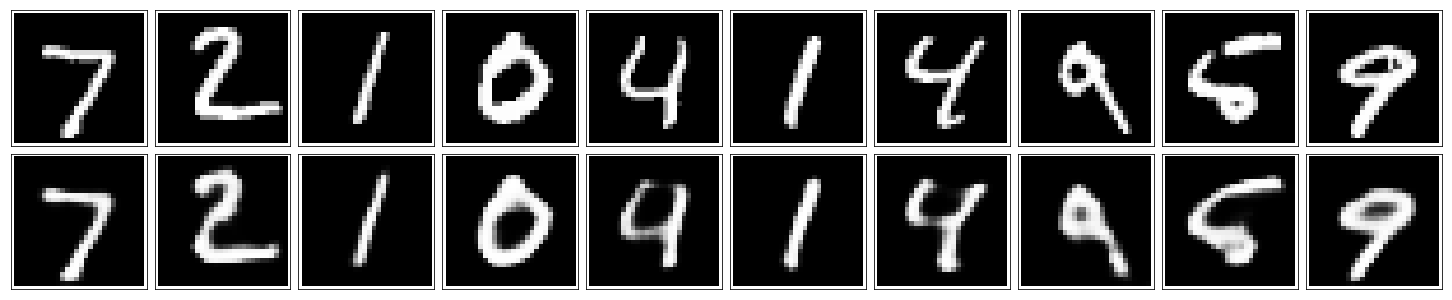

In [17]:
modelRunner.run_autoencoder(
    convAutoencoder, mnist, image_shape, epochs, batch_size, True)

# Running Denoising Autoencoder

In [18]:
conv_outputs = (None,32,32,16,16,32,32)

In [19]:
denoisingAutoencoder = ConvolutionalAutoencoder()

denoisingAutoencoder.build(image_shape, learning_rate, conv_outputs)


Building a convolutional autoencoder ...

Convolutional autoencoder built



In [21]:
noise_factor = 0.5


Training autoencoder ...

Epoch: 1/20... Training loss: 0.6887
Epoch: 1/20... Training loss: 0.6699
Epoch: 1/20... Training loss: 0.6457
Epoch: 1/20... Training loss: 0.6081
Epoch: 1/20... Training loss: 0.5630
Epoch: 1/20... Training loss: 0.5160
Epoch: 1/20... Training loss: 0.4925
Epoch: 1/20... Training loss: 0.5246
Epoch: 1/20... Training loss: 0.5190
Epoch: 1/20... Training loss: 0.4985
Epoch: 1/20... Training loss: 0.4687
Epoch: 1/20... Training loss: 0.4658
Epoch: 1/20... Training loss: 0.4557
Epoch: 1/20... Training loss: 0.4467
Epoch: 1/20... Training loss: 0.4380
Epoch: 1/20... Training loss: 0.4318
Epoch: 1/20... Training loss: 0.4260
Epoch: 1/20... Training loss: 0.4081
Epoch: 1/20... Training loss: 0.3949
Epoch: 1/20... Training loss: 0.3949
Epoch: 1/20... Training loss: 0.3761
Epoch: 1/20... Training loss: 0.3638
Epoch: 1/20... Training loss: 0.3571
Epoch: 1/20... Training loss: 0.3358
Epoch: 1/20... Training loss: 0.3287
Epoch: 1/20... Training loss: 0.3125
Epoch: 1/20

Epoch: 1/20... Training loss: 0.1800
Epoch: 1/20... Training loss: 0.1821
Epoch: 1/20... Training loss: 0.1764
Epoch: 1/20... Training loss: 0.1838
Epoch: 1/20... Training loss: 0.1831
Epoch: 1/20... Training loss: 0.1807
Epoch: 1/20... Training loss: 0.1846
Epoch: 1/20... Training loss: 0.1846
Epoch: 1/20... Training loss: 0.1822
Epoch: 1/20... Training loss: 0.1873
Epoch: 1/20... Training loss: 0.1840
Epoch: 1/20... Training loss: 0.1787
Epoch: 1/20... Training loss: 0.1825
Epoch: 1/20... Training loss: 0.1816
Epoch: 1/20... Training loss: 0.1804
Epoch: 1/20... Training loss: 0.1807
Epoch: 1/20... Training loss: 0.1794
Epoch: 1/20... Training loss: 0.1750
Epoch: 1/20... Training loss: 0.1838
Epoch: 1/20... Training loss: 0.1810
Epoch: 1/20... Training loss: 0.1813
Epoch: 1/20... Training loss: 0.1806
Epoch: 1/20... Training loss: 0.1799
Epoch: 1/20... Training loss: 0.1811
Epoch: 1/20... Training loss: 0.1807
Epoch: 1/20... Training loss: 0.1780
Epoch: 1/20... Training loss: 0.1786
E

Epoch: 2/20... Training loss: 0.1544
Epoch: 2/20... Training loss: 0.1507
Epoch: 2/20... Training loss: 0.1575
Epoch: 2/20... Training loss: 0.1544
Epoch: 2/20... Training loss: 0.1578
Epoch: 2/20... Training loss: 0.1527
Epoch: 2/20... Training loss: 0.1527
Epoch: 2/20... Training loss: 0.1550
Epoch: 2/20... Training loss: 0.1524
Epoch: 2/20... Training loss: 0.1590
Epoch: 2/20... Training loss: 0.1484
Epoch: 2/20... Training loss: 0.1508
Epoch: 2/20... Training loss: 0.1539
Epoch: 2/20... Training loss: 0.1495
Epoch: 2/20... Training loss: 0.1496
Epoch: 2/20... Training loss: 0.1515
Epoch: 2/20... Training loss: 0.1491
Epoch: 2/20... Training loss: 0.1461
Epoch: 2/20... Training loss: 0.1504
Epoch: 2/20... Training loss: 0.1507
Epoch: 2/20... Training loss: 0.1531
Epoch: 2/20... Training loss: 0.1521
Epoch: 2/20... Training loss: 0.1486
Epoch: 2/20... Training loss: 0.1554
Epoch: 2/20... Training loss: 0.1536
Epoch: 2/20... Training loss: 0.1505
Epoch: 2/20... Training loss: 0.1487
E

Epoch: 3/20... Training loss: 0.1403
Epoch: 3/20... Training loss: 0.1409
Epoch: 3/20... Training loss: 0.1449
Epoch: 3/20... Training loss: 0.1438
Epoch: 3/20... Training loss: 0.1424
Epoch: 3/20... Training loss: 0.1389
Epoch: 3/20... Training loss: 0.1381
Epoch: 3/20... Training loss: 0.1388
Epoch: 3/20... Training loss: 0.1425
Epoch: 3/20... Training loss: 0.1380
Epoch: 3/20... Training loss: 0.1423
Epoch: 3/20... Training loss: 0.1422
Epoch: 3/20... Training loss: 0.1377
Epoch: 3/20... Training loss: 0.1393
Epoch: 3/20... Training loss: 0.1378
Epoch: 3/20... Training loss: 0.1388
Epoch: 3/20... Training loss: 0.1359
Epoch: 3/20... Training loss: 0.1439
Epoch: 3/20... Training loss: 0.1360
Epoch: 3/20... Training loss: 0.1379
Epoch: 3/20... Training loss: 0.1346
Epoch: 3/20... Training loss: 0.1359
Epoch: 3/20... Training loss: 0.1429
Epoch: 3/20... Training loss: 0.1418
Epoch: 3/20... Training loss: 0.1426
Epoch: 3/20... Training loss: 0.1392
Epoch: 3/20... Training loss: 0.1393
E

Epoch: 3/20... Training loss: 0.1297
Epoch: 3/20... Training loss: 0.1328
Epoch: 3/20... Training loss: 0.1337
Epoch: 3/20... Training loss: 0.1306
Epoch: 3/20... Training loss: 0.1302
Epoch: 3/20... Training loss: 0.1348
Epoch: 3/20... Training loss: 0.1329
Epoch: 4/20... Training loss: 0.1339
Epoch: 4/20... Training loss: 0.1384
Epoch: 4/20... Training loss: 0.1320
Epoch: 4/20... Training loss: 0.1358
Epoch: 4/20... Training loss: 0.1347
Epoch: 4/20... Training loss: 0.1340
Epoch: 4/20... Training loss: 0.1298
Epoch: 4/20... Training loss: 0.1334
Epoch: 4/20... Training loss: 0.1287
Epoch: 4/20... Training loss: 0.1305
Epoch: 4/20... Training loss: 0.1287
Epoch: 4/20... Training loss: 0.1323
Epoch: 4/20... Training loss: 0.1305
Epoch: 4/20... Training loss: 0.1312
Epoch: 4/20... Training loss: 0.1321
Epoch: 4/20... Training loss: 0.1340
Epoch: 4/20... Training loss: 0.1299
Epoch: 4/20... Training loss: 0.1303
Epoch: 4/20... Training loss: 0.1287
Epoch: 4/20... Training loss: 0.1334
E

Epoch: 4/20... Training loss: 0.1249
Epoch: 4/20... Training loss: 0.1251
Epoch: 4/20... Training loss: 0.1238
Epoch: 4/20... Training loss: 0.1313
Epoch: 4/20... Training loss: 0.1256
Epoch: 4/20... Training loss: 0.1223
Epoch: 4/20... Training loss: 0.1240
Epoch: 4/20... Training loss: 0.1261
Epoch: 4/20... Training loss: 0.1271
Epoch: 4/20... Training loss: 0.1272
Epoch: 4/20... Training loss: 0.1255
Epoch: 4/20... Training loss: 0.1259
Epoch: 4/20... Training loss: 0.1281
Epoch: 4/20... Training loss: 0.1270
Epoch: 4/20... Training loss: 0.1276
Epoch: 4/20... Training loss: 0.1247
Epoch: 4/20... Training loss: 0.1259
Epoch: 4/20... Training loss: 0.1284
Epoch: 4/20... Training loss: 0.1279
Epoch: 4/20... Training loss: 0.1285
Epoch: 4/20... Training loss: 0.1218
Epoch: 4/20... Training loss: 0.1288
Epoch: 4/20... Training loss: 0.1233
Epoch: 4/20... Training loss: 0.1262
Epoch: 4/20... Training loss: 0.1319
Epoch: 4/20... Training loss: 0.1314
Epoch: 4/20... Training loss: 0.1290
E

Epoch: 5/20... Training loss: 0.1245
Epoch: 5/20... Training loss: 0.1235
Epoch: 5/20... Training loss: 0.1198
Epoch: 5/20... Training loss: 0.1272
Epoch: 5/20... Training loss: 0.1301
Epoch: 5/20... Training loss: 0.1213
Epoch: 5/20... Training loss: 0.1204
Epoch: 5/20... Training loss: 0.1197
Epoch: 5/20... Training loss: 0.1251
Epoch: 5/20... Training loss: 0.1229
Epoch: 5/20... Training loss: 0.1276
Epoch: 5/20... Training loss: 0.1249
Epoch: 5/20... Training loss: 0.1319
Epoch: 5/20... Training loss: 0.1242
Epoch: 5/20... Training loss: 0.1253
Epoch: 5/20... Training loss: 0.1276
Epoch: 5/20... Training loss: 0.1223
Epoch: 5/20... Training loss: 0.1245
Epoch: 5/20... Training loss: 0.1243
Epoch: 5/20... Training loss: 0.1248
Epoch: 5/20... Training loss: 0.1212
Epoch: 5/20... Training loss: 0.1201
Epoch: 5/20... Training loss: 0.1237
Epoch: 5/20... Training loss: 0.1280
Epoch: 5/20... Training loss: 0.1217
Epoch: 5/20... Training loss: 0.1282
Epoch: 5/20... Training loss: 0.1251
E

Epoch: 6/20... Training loss: 0.1210
Epoch: 6/20... Training loss: 0.1235
Epoch: 6/20... Training loss: 0.1170
Epoch: 6/20... Training loss: 0.1228
Epoch: 6/20... Training loss: 0.1172
Epoch: 6/20... Training loss: 0.1172
Epoch: 6/20... Training loss: 0.1250
Epoch: 6/20... Training loss: 0.1186
Epoch: 6/20... Training loss: 0.1239
Epoch: 6/20... Training loss: 0.1219
Epoch: 6/20... Training loss: 0.1206
Epoch: 6/20... Training loss: 0.1189
Epoch: 6/20... Training loss: 0.1251
Epoch: 6/20... Training loss: 0.1199
Epoch: 6/20... Training loss: 0.1184
Epoch: 6/20... Training loss: 0.1232
Epoch: 6/20... Training loss: 0.1193
Epoch: 6/20... Training loss: 0.1238
Epoch: 6/20... Training loss: 0.1203
Epoch: 6/20... Training loss: 0.1195
Epoch: 6/20... Training loss: 0.1218
Epoch: 6/20... Training loss: 0.1241
Epoch: 6/20... Training loss: 0.1228
Epoch: 6/20... Training loss: 0.1227
Epoch: 6/20... Training loss: 0.1241
Epoch: 6/20... Training loss: 0.1212
Epoch: 6/20... Training loss: 0.1230
E

Epoch: 6/20... Training loss: 0.1183
Epoch: 6/20... Training loss: 0.1197
Epoch: 6/20... Training loss: 0.1233
Epoch: 6/20... Training loss: 0.1212
Epoch: 6/20... Training loss: 0.1176
Epoch: 6/20... Training loss: 0.1204
Epoch: 6/20... Training loss: 0.1160
Epoch: 6/20... Training loss: 0.1184
Epoch: 6/20... Training loss: 0.1179
Epoch: 6/20... Training loss: 0.1181
Epoch: 7/20... Training loss: 0.1188
Epoch: 7/20... Training loss: 0.1170
Epoch: 7/20... Training loss: 0.1180
Epoch: 7/20... Training loss: 0.1211
Epoch: 7/20... Training loss: 0.1205
Epoch: 7/20... Training loss: 0.1201
Epoch: 7/20... Training loss: 0.1191
Epoch: 7/20... Training loss: 0.1225
Epoch: 7/20... Training loss: 0.1162
Epoch: 7/20... Training loss: 0.1187
Epoch: 7/20... Training loss: 0.1209
Epoch: 7/20... Training loss: 0.1175
Epoch: 7/20... Training loss: 0.1205
Epoch: 7/20... Training loss: 0.1211
Epoch: 7/20... Training loss: 0.1154
Epoch: 7/20... Training loss: 0.1197
Epoch: 7/20... Training loss: 0.1168
E

Epoch: 7/20... Training loss: 0.1213
Epoch: 7/20... Training loss: 0.1223
Epoch: 7/20... Training loss: 0.1192
Epoch: 7/20... Training loss: 0.1184
Epoch: 7/20... Training loss: 0.1172
Epoch: 7/20... Training loss: 0.1191
Epoch: 7/20... Training loss: 0.1182
Epoch: 7/20... Training loss: 0.1159
Epoch: 7/20... Training loss: 0.1150
Epoch: 7/20... Training loss: 0.1152
Epoch: 7/20... Training loss: 0.1225
Epoch: 7/20... Training loss: 0.1146
Epoch: 7/20... Training loss: 0.1132
Epoch: 7/20... Training loss: 0.1203
Epoch: 7/20... Training loss: 0.1182
Epoch: 7/20... Training loss: 0.1161
Epoch: 7/20... Training loss: 0.1190
Epoch: 7/20... Training loss: 0.1174
Epoch: 7/20... Training loss: 0.1227
Epoch: 7/20... Training loss: 0.1165
Epoch: 7/20... Training loss: 0.1191
Epoch: 7/20... Training loss: 0.1170
Epoch: 7/20... Training loss: 0.1169
Epoch: 7/20... Training loss: 0.1177
Epoch: 7/20... Training loss: 0.1201
Epoch: 7/20... Training loss: 0.1183
Epoch: 7/20... Training loss: 0.1203
E

Epoch: 8/20... Training loss: 0.1172
Epoch: 8/20... Training loss: 0.1147
Epoch: 8/20... Training loss: 0.1183
Epoch: 8/20... Training loss: 0.1173
Epoch: 8/20... Training loss: 0.1193
Epoch: 8/20... Training loss: 0.1150
Epoch: 8/20... Training loss: 0.1153
Epoch: 8/20... Training loss: 0.1179
Epoch: 8/20... Training loss: 0.1162
Epoch: 8/20... Training loss: 0.1184
Epoch: 8/20... Training loss: 0.1154
Epoch: 8/20... Training loss: 0.1177
Epoch: 8/20... Training loss: 0.1213
Epoch: 8/20... Training loss: 0.1121
Epoch: 8/20... Training loss: 0.1178
Epoch: 8/20... Training loss: 0.1137
Epoch: 8/20... Training loss: 0.1171
Epoch: 8/20... Training loss: 0.1145
Epoch: 8/20... Training loss: 0.1134
Epoch: 8/20... Training loss: 0.1147
Epoch: 8/20... Training loss: 0.1147
Epoch: 8/20... Training loss: 0.1166
Epoch: 8/20... Training loss: 0.1178
Epoch: 8/20... Training loss: 0.1127
Epoch: 8/20... Training loss: 0.1138
Epoch: 8/20... Training loss: 0.1179
Epoch: 8/20... Training loss: 0.1141
E

Epoch: 9/20... Training loss: 0.1127
Epoch: 9/20... Training loss: 0.1166
Epoch: 9/20... Training loss: 0.1123
Epoch: 9/20... Training loss: 0.1145
Epoch: 9/20... Training loss: 0.1158
Epoch: 9/20... Training loss: 0.1148
Epoch: 9/20... Training loss: 0.1151
Epoch: 9/20... Training loss: 0.1128
Epoch: 9/20... Training loss: 0.1149
Epoch: 9/20... Training loss: 0.1128
Epoch: 9/20... Training loss: 0.1167
Epoch: 9/20... Training loss: 0.1140
Epoch: 9/20... Training loss: 0.1157
Epoch: 9/20... Training loss: 0.1155
Epoch: 9/20... Training loss: 0.1130
Epoch: 9/20... Training loss: 0.1163
Epoch: 9/20... Training loss: 0.1164
Epoch: 9/20... Training loss: 0.1206
Epoch: 9/20... Training loss: 0.1156
Epoch: 9/20... Training loss: 0.1153
Epoch: 9/20... Training loss: 0.1152
Epoch: 9/20... Training loss: 0.1175
Epoch: 9/20... Training loss: 0.1178
Epoch: 9/20... Training loss: 0.1152
Epoch: 9/20... Training loss: 0.1162
Epoch: 9/20... Training loss: 0.1141
Epoch: 9/20... Training loss: 0.1156
E

Epoch: 9/20... Training loss: 0.1160
Epoch: 9/20... Training loss: 0.1123
Epoch: 9/20... Training loss: 0.1121
Epoch: 9/20... Training loss: 0.1131
Epoch: 9/20... Training loss: 0.1118
Epoch: 9/20... Training loss: 0.1174
Epoch: 9/20... Training loss: 0.1155
Epoch: 9/20... Training loss: 0.1140
Epoch: 9/20... Training loss: 0.1153
Epoch: 9/20... Training loss: 0.1135
Epoch: 9/20... Training loss: 0.1188
Epoch: 9/20... Training loss: 0.1153
Epoch: 9/20... Training loss: 0.1143
Epoch: 10/20... Training loss: 0.1152
Epoch: 10/20... Training loss: 0.1138
Epoch: 10/20... Training loss: 0.1138
Epoch: 10/20... Training loss: 0.1164
Epoch: 10/20... Training loss: 0.1148
Epoch: 10/20... Training loss: 0.1093
Epoch: 10/20... Training loss: 0.1105
Epoch: 10/20... Training loss: 0.1125
Epoch: 10/20... Training loss: 0.1112
Epoch: 10/20... Training loss: 0.1138
Epoch: 10/20... Training loss: 0.1104
Epoch: 10/20... Training loss: 0.1165
Epoch: 10/20... Training loss: 0.1132
Epoch: 10/20... Training 

Epoch: 10/20... Training loss: 0.1121
Epoch: 10/20... Training loss: 0.1122
Epoch: 10/20... Training loss: 0.1110
Epoch: 10/20... Training loss: 0.1154
Epoch: 10/20... Training loss: 0.1142
Epoch: 10/20... Training loss: 0.1119
Epoch: 10/20... Training loss: 0.1164
Epoch: 10/20... Training loss: 0.1193
Epoch: 10/20... Training loss: 0.1119
Epoch: 10/20... Training loss: 0.1124
Epoch: 10/20... Training loss: 0.1136
Epoch: 10/20... Training loss: 0.1153
Epoch: 10/20... Training loss: 0.1117
Epoch: 10/20... Training loss: 0.1095
Epoch: 10/20... Training loss: 0.1099
Epoch: 10/20... Training loss: 0.1131
Epoch: 10/20... Training loss: 0.1105
Epoch: 10/20... Training loss: 0.1155
Epoch: 10/20... Training loss: 0.1089
Epoch: 10/20... Training loss: 0.1146
Epoch: 10/20... Training loss: 0.1124
Epoch: 10/20... Training loss: 0.1128
Epoch: 10/20... Training loss: 0.1096
Epoch: 10/20... Training loss: 0.1127
Epoch: 10/20... Training loss: 0.1125
Epoch: 10/20... Training loss: 0.1141
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1122
Epoch: 11/20... Training loss: 0.1089
Epoch: 11/20... Training loss: 0.1181
Epoch: 11/20... Training loss: 0.1120
Epoch: 11/20... Training loss: 0.1127
Epoch: 11/20... Training loss: 0.1127
Epoch: 11/20... Training loss: 0.1158
Epoch: 11/20... Training loss: 0.1136
Epoch: 11/20... Training loss: 0.1143
Epoch: 11/20... Training loss: 0.1116
Epoch: 11/20... Training loss: 0.1108
Epoch: 11/20... Training loss: 0.1179
Epoch: 11/20... Training loss: 0.1144
Epoch: 11/20... Training loss: 0.1131
Epoch: 11/20... Training loss: 0.1106
Epoch: 11/20... Training loss: 0.1105
Epoch: 11/20... Training loss: 0.1098
Epoch: 11/20... Training loss: 0.1124
Epoch: 11/20... Training loss: 0.1146
Epoch: 11/20... Training loss: 0.1136
Epoch: 11/20... Training loss: 0.1130
Epoch: 11/20... Training loss: 0.1159
Epoch: 11/20... Training loss: 0.1118
Epoch: 11/20... Training loss: 0.1094
Epoch: 11/20... Training loss: 0.1160
Epoch: 11/20... Training loss: 0.1093
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1137
Epoch: 12/20... Training loss: 0.1084
Epoch: 12/20... Training loss: 0.1116
Epoch: 12/20... Training loss: 0.1132
Epoch: 12/20... Training loss: 0.1135
Epoch: 12/20... Training loss: 0.1117
Epoch: 12/20... Training loss: 0.1128
Epoch: 12/20... Training loss: 0.1105
Epoch: 12/20... Training loss: 0.1117
Epoch: 12/20... Training loss: 0.1126
Epoch: 12/20... Training loss: 0.1116
Epoch: 12/20... Training loss: 0.1113
Epoch: 12/20... Training loss: 0.1127
Epoch: 12/20... Training loss: 0.1098
Epoch: 12/20... Training loss: 0.1113
Epoch: 12/20... Training loss: 0.1134
Epoch: 12/20... Training loss: 0.1106
Epoch: 12/20... Training loss: 0.1158
Epoch: 12/20... Training loss: 0.1136
Epoch: 12/20... Training loss: 0.1136
Epoch: 12/20... Training loss: 0.1136
Epoch: 12/20... Training loss: 0.1135
Epoch: 12/20... Training loss: 0.1102
Epoch: 12/20... Training loss: 0.1122
Epoch: 12/20... Training loss: 0.1128
Epoch: 12/20... Training loss: 0.1082
Epoch: 12/20

Epoch: 12/20... Training loss: 0.1141
Epoch: 12/20... Training loss: 0.1101
Epoch: 12/20... Training loss: 0.1124
Epoch: 12/20... Training loss: 0.1146
Epoch: 12/20... Training loss: 0.1154
Epoch: 12/20... Training loss: 0.1106
Epoch: 12/20... Training loss: 0.1106
Epoch: 12/20... Training loss: 0.1136
Epoch: 12/20... Training loss: 0.1136
Epoch: 12/20... Training loss: 0.1151
Epoch: 12/20... Training loss: 0.1176
Epoch: 12/20... Training loss: 0.1118
Epoch: 12/20... Training loss: 0.1189
Epoch: 12/20... Training loss: 0.1128
Epoch: 12/20... Training loss: 0.1123
Epoch: 12/20... Training loss: 0.1135
Epoch: 12/20... Training loss: 0.1122
Epoch: 12/20... Training loss: 0.1137
Epoch: 12/20... Training loss: 0.1103
Epoch: 12/20... Training loss: 0.1104
Epoch: 12/20... Training loss: 0.1110
Epoch: 12/20... Training loss: 0.1117
Epoch: 12/20... Training loss: 0.1086
Epoch: 12/20... Training loss: 0.1082
Epoch: 12/20... Training loss: 0.1109
Epoch: 12/20... Training loss: 0.1118
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1143
Epoch: 13/20... Training loss: 0.1094
Epoch: 13/20... Training loss: 0.1098
Epoch: 13/20... Training loss: 0.1091
Epoch: 13/20... Training loss: 0.1090
Epoch: 13/20... Training loss: 0.1121
Epoch: 13/20... Training loss: 0.1132
Epoch: 13/20... Training loss: 0.1096
Epoch: 13/20... Training loss: 0.1127
Epoch: 13/20... Training loss: 0.1112
Epoch: 13/20... Training loss: 0.1148
Epoch: 13/20... Training loss: 0.1102
Epoch: 13/20... Training loss: 0.1088
Epoch: 13/20... Training loss: 0.1100
Epoch: 13/20... Training loss: 0.1114
Epoch: 13/20... Training loss: 0.1091
Epoch: 13/20... Training loss: 0.1072
Epoch: 13/20... Training loss: 0.1131
Epoch: 13/20... Training loss: 0.1099
Epoch: 13/20... Training loss: 0.1134
Epoch: 13/20... Training loss: 0.1120
Epoch: 13/20... Training loss: 0.1141
Epoch: 13/20... Training loss: 0.1121
Epoch: 13/20... Training loss: 0.1108
Epoch: 13/20... Training loss: 0.1115
Epoch: 13/20... Training loss: 0.1136
Epoch: 13/20

Epoch: 14/20... Training loss: 0.1124
Epoch: 14/20... Training loss: 0.1118
Epoch: 14/20... Training loss: 0.1092
Epoch: 14/20... Training loss: 0.1104
Epoch: 14/20... Training loss: 0.1104
Epoch: 14/20... Training loss: 0.1072
Epoch: 14/20... Training loss: 0.1097
Epoch: 14/20... Training loss: 0.1118
Epoch: 14/20... Training loss: 0.1082
Epoch: 14/20... Training loss: 0.1093
Epoch: 14/20... Training loss: 0.1108
Epoch: 14/20... Training loss: 0.1059
Epoch: 14/20... Training loss: 0.1129
Epoch: 14/20... Training loss: 0.1090
Epoch: 14/20... Training loss: 0.1084
Epoch: 14/20... Training loss: 0.1135
Epoch: 14/20... Training loss: 0.1085
Epoch: 14/20... Training loss: 0.1112
Epoch: 14/20... Training loss: 0.1121
Epoch: 14/20... Training loss: 0.1084
Epoch: 14/20... Training loss: 0.1097
Epoch: 14/20... Training loss: 0.1105
Epoch: 14/20... Training loss: 0.1100
Epoch: 14/20... Training loss: 0.1104
Epoch: 14/20... Training loss: 0.1105
Epoch: 14/20... Training loss: 0.1142
Epoch: 14/20

Epoch: 15/20... Training loss: 0.1072
Epoch: 15/20... Training loss: 0.1131
Epoch: 15/20... Training loss: 0.1124
Epoch: 15/20... Training loss: 0.1067
Epoch: 15/20... Training loss: 0.1116
Epoch: 15/20... Training loss: 0.1087
Epoch: 15/20... Training loss: 0.1113
Epoch: 15/20... Training loss: 0.1100
Epoch: 15/20... Training loss: 0.1064
Epoch: 15/20... Training loss: 0.1103
Epoch: 15/20... Training loss: 0.1102
Epoch: 15/20... Training loss: 0.1080
Epoch: 15/20... Training loss: 0.1083
Epoch: 15/20... Training loss: 0.1071
Epoch: 15/20... Training loss: 0.1080
Epoch: 15/20... Training loss: 0.1119
Epoch: 15/20... Training loss: 0.1124
Epoch: 15/20... Training loss: 0.1109
Epoch: 15/20... Training loss: 0.1110
Epoch: 15/20... Training loss: 0.1093
Epoch: 15/20... Training loss: 0.1113
Epoch: 15/20... Training loss: 0.1091
Epoch: 15/20... Training loss: 0.1105
Epoch: 15/20... Training loss: 0.1113
Epoch: 15/20... Training loss: 0.1134
Epoch: 15/20... Training loss: 0.1109
Epoch: 15/20

Epoch: 15/20... Training loss: 0.1097
Epoch: 15/20... Training loss: 0.1091
Epoch: 15/20... Training loss: 0.1076
Epoch: 15/20... Training loss: 0.1094
Epoch: 15/20... Training loss: 0.1086
Epoch: 15/20... Training loss: 0.1103
Epoch: 15/20... Training loss: 0.1090
Epoch: 15/20... Training loss: 0.1110
Epoch: 15/20... Training loss: 0.1142
Epoch: 15/20... Training loss: 0.1074
Epoch: 15/20... Training loss: 0.1074
Epoch: 15/20... Training loss: 0.1104
Epoch: 15/20... Training loss: 0.1094
Epoch: 15/20... Training loss: 0.1129
Epoch: 15/20... Training loss: 0.1057
Epoch: 15/20... Training loss: 0.1071
Epoch: 15/20... Training loss: 0.1111
Epoch: 15/20... Training loss: 0.1084
Epoch: 15/20... Training loss: 0.1066
Epoch: 15/20... Training loss: 0.1104
Epoch: 15/20... Training loss: 0.1072
Epoch: 15/20... Training loss: 0.1107
Epoch: 15/20... Training loss: 0.1103
Epoch: 15/20... Training loss: 0.1072
Epoch: 15/20... Training loss: 0.1127
Epoch: 15/20... Training loss: 0.1078
Epoch: 15/20

Epoch: 16/20... Training loss: 0.1124
Epoch: 16/20... Training loss: 0.1087
Epoch: 16/20... Training loss: 0.1104
Epoch: 16/20... Training loss: 0.1095
Epoch: 16/20... Training loss: 0.1122
Epoch: 16/20... Training loss: 0.1049
Epoch: 16/20... Training loss: 0.1078
Epoch: 16/20... Training loss: 0.1081
Epoch: 16/20... Training loss: 0.1097
Epoch: 16/20... Training loss: 0.1072
Epoch: 16/20... Training loss: 0.1093
Epoch: 16/20... Training loss: 0.1069
Epoch: 16/20... Training loss: 0.1096
Epoch: 16/20... Training loss: 0.1022
Epoch: 16/20... Training loss: 0.1089
Epoch: 16/20... Training loss: 0.1097
Epoch: 16/20... Training loss: 0.1110
Epoch: 16/20... Training loss: 0.1068
Epoch: 16/20... Training loss: 0.1086
Epoch: 16/20... Training loss: 0.1085
Epoch: 16/20... Training loss: 0.1092
Epoch: 16/20... Training loss: 0.1098
Epoch: 16/20... Training loss: 0.1103
Epoch: 16/20... Training loss: 0.1097
Epoch: 16/20... Training loss: 0.1060
Epoch: 16/20... Training loss: 0.1103
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1107
Epoch: 17/20... Training loss: 0.1112
Epoch: 17/20... Training loss: 0.1065
Epoch: 17/20... Training loss: 0.1113
Epoch: 17/20... Training loss: 0.1094
Epoch: 17/20... Training loss: 0.1089
Epoch: 17/20... Training loss: 0.1094
Epoch: 17/20... Training loss: 0.1075
Epoch: 17/20... Training loss: 0.1083
Epoch: 17/20... Training loss: 0.1087
Epoch: 17/20... Training loss: 0.1094
Epoch: 17/20... Training loss: 0.1097
Epoch: 17/20... Training loss: 0.1085
Epoch: 17/20... Training loss: 0.1118
Epoch: 17/20... Training loss: 0.1051
Epoch: 17/20... Training loss: 0.1074
Epoch: 17/20... Training loss: 0.1078
Epoch: 17/20... Training loss: 0.1084
Epoch: 17/20... Training loss: 0.1110
Epoch: 17/20... Training loss: 0.1085
Epoch: 17/20... Training loss: 0.1103
Epoch: 17/20... Training loss: 0.1132
Epoch: 17/20... Training loss: 0.1111
Epoch: 17/20... Training loss: 0.1072
Epoch: 17/20... Training loss: 0.1090
Epoch: 17/20... Training loss: 0.1053
Epoch: 17/20

Epoch: 17/20... Training loss: 0.1060
Epoch: 17/20... Training loss: 0.1089
Epoch: 17/20... Training loss: 0.1096
Epoch: 17/20... Training loss: 0.1106
Epoch: 17/20... Training loss: 0.1094
Epoch: 17/20... Training loss: 0.1049
Epoch: 17/20... Training loss: 0.1093
Epoch: 17/20... Training loss: 0.1125
Epoch: 17/20... Training loss: 0.1092
Epoch: 17/20... Training loss: 0.1094
Epoch: 17/20... Training loss: 0.1068
Epoch: 17/20... Training loss: 0.1109
Epoch: 17/20... Training loss: 0.1112
Epoch: 17/20... Training loss: 0.1091
Epoch: 17/20... Training loss: 0.1054
Epoch: 17/20... Training loss: 0.1047
Epoch: 17/20... Training loss: 0.1105
Epoch: 17/20... Training loss: 0.1078
Epoch: 17/20... Training loss: 0.1099
Epoch: 18/20... Training loss: 0.1047
Epoch: 18/20... Training loss: 0.1083
Epoch: 18/20... Training loss: 0.1074
Epoch: 18/20... Training loss: 0.1044
Epoch: 18/20... Training loss: 0.1077
Epoch: 18/20... Training loss: 0.1070
Epoch: 18/20... Training loss: 0.1098
Epoch: 18/20

Epoch: 18/20... Training loss: 0.1106
Epoch: 18/20... Training loss: 0.1068
Epoch: 18/20... Training loss: 0.1050
Epoch: 18/20... Training loss: 0.1115
Epoch: 18/20... Training loss: 0.1082
Epoch: 18/20... Training loss: 0.1059
Epoch: 18/20... Training loss: 0.1058
Epoch: 18/20... Training loss: 0.1068
Epoch: 18/20... Training loss: 0.1051
Epoch: 18/20... Training loss: 0.1092
Epoch: 18/20... Training loss: 0.1085
Epoch: 18/20... Training loss: 0.1085
Epoch: 18/20... Training loss: 0.1102
Epoch: 18/20... Training loss: 0.1059
Epoch: 18/20... Training loss: 0.1077
Epoch: 18/20... Training loss: 0.1111
Epoch: 18/20... Training loss: 0.1083
Epoch: 18/20... Training loss: 0.1084
Epoch: 18/20... Training loss: 0.1076
Epoch: 18/20... Training loss: 0.1124
Epoch: 18/20... Training loss: 0.1085
Epoch: 18/20... Training loss: 0.1080
Epoch: 18/20... Training loss: 0.1067
Epoch: 18/20... Training loss: 0.1097
Epoch: 18/20... Training loss: 0.1086
Epoch: 18/20... Training loss: 0.1093
Epoch: 18/20

Epoch: 19/20... Training loss: 0.1084
Epoch: 19/20... Training loss: 0.1060
Epoch: 19/20... Training loss: 0.1061
Epoch: 19/20... Training loss: 0.1057
Epoch: 19/20... Training loss: 0.1098
Epoch: 19/20... Training loss: 0.1095
Epoch: 19/20... Training loss: 0.1077
Epoch: 19/20... Training loss: 0.1041
Epoch: 19/20... Training loss: 0.1093
Epoch: 19/20... Training loss: 0.1067
Epoch: 19/20... Training loss: 0.1063
Epoch: 19/20... Training loss: 0.1068
Epoch: 19/20... Training loss: 0.1064
Epoch: 19/20... Training loss: 0.1067
Epoch: 19/20... Training loss: 0.1075
Epoch: 19/20... Training loss: 0.1050
Epoch: 19/20... Training loss: 0.1076
Epoch: 19/20... Training loss: 0.1043
Epoch: 19/20... Training loss: 0.1051
Epoch: 19/20... Training loss: 0.1076
Epoch: 19/20... Training loss: 0.1077
Epoch: 19/20... Training loss: 0.1048
Epoch: 19/20... Training loss: 0.1072
Epoch: 19/20... Training loss: 0.1083
Epoch: 19/20... Training loss: 0.1099
Epoch: 19/20... Training loss: 0.1068
Epoch: 19/20

Epoch: 20/20... Training loss: 0.1097
Epoch: 20/20... Training loss: 0.1087
Epoch: 20/20... Training loss: 0.1076
Epoch: 20/20... Training loss: 0.1056
Epoch: 20/20... Training loss: 0.1060
Epoch: 20/20... Training loss: 0.1040
Epoch: 20/20... Training loss: 0.1085
Epoch: 20/20... Training loss: 0.1072
Epoch: 20/20... Training loss: 0.1060
Epoch: 20/20... Training loss: 0.1085
Epoch: 20/20... Training loss: 0.1079
Epoch: 20/20... Training loss: 0.1063
Epoch: 20/20... Training loss: 0.1058
Epoch: 20/20... Training loss: 0.1069
Epoch: 20/20... Training loss: 0.1088
Epoch: 20/20... Training loss: 0.1095
Epoch: 20/20... Training loss: 0.1048
Epoch: 20/20... Training loss: 0.1086
Epoch: 20/20... Training loss: 0.1074
Epoch: 20/20... Training loss: 0.1105
Epoch: 20/20... Training loss: 0.1061
Epoch: 20/20... Training loss: 0.1113
Epoch: 20/20... Training loss: 0.1072
Epoch: 20/20... Training loss: 0.1069
Epoch: 20/20... Training loss: 0.1059
Epoch: 20/20... Training loss: 0.1099
Epoch: 20/20

Epoch: 20/20... Training loss: 0.1067
Epoch: 20/20... Training loss: 0.1070
Epoch: 20/20... Training loss: 0.1095
Epoch: 20/20... Training loss: 0.1091
Epoch: 20/20... Training loss: 0.1097
Epoch: 20/20... Training loss: 0.1113
Epoch: 20/20... Training loss: 0.1090
Epoch: 20/20... Training loss: 0.1045
Epoch: 20/20... Training loss: 0.1106
Epoch: 20/20... Training loss: 0.1083
Epoch: 20/20... Training loss: 0.1064
Epoch: 20/20... Training loss: 0.1096
Epoch: 20/20... Training loss: 0.1022
Epoch: 20/20... Training loss: 0.1035
Epoch: 20/20... Training loss: 0.1108
Epoch: 20/20... Training loss: 0.1075
Epoch: 20/20... Training loss: 0.1044
Epoch: 20/20... Training loss: 0.1098
Epoch: 20/20... Training loss: 0.1023
Epoch: 20/20... Training loss: 0.1079
Epoch: 20/20... Training loss: 0.1055
Epoch: 20/20... Training loss: 0.1093
Epoch: 20/20... Training loss: 0.1053
Epoch: 20/20... Training loss: 0.1063
Epoch: 20/20... Training loss: 0.1091
Epoch: 20/20... Training loss: 0.1092
Epoch: 20/20

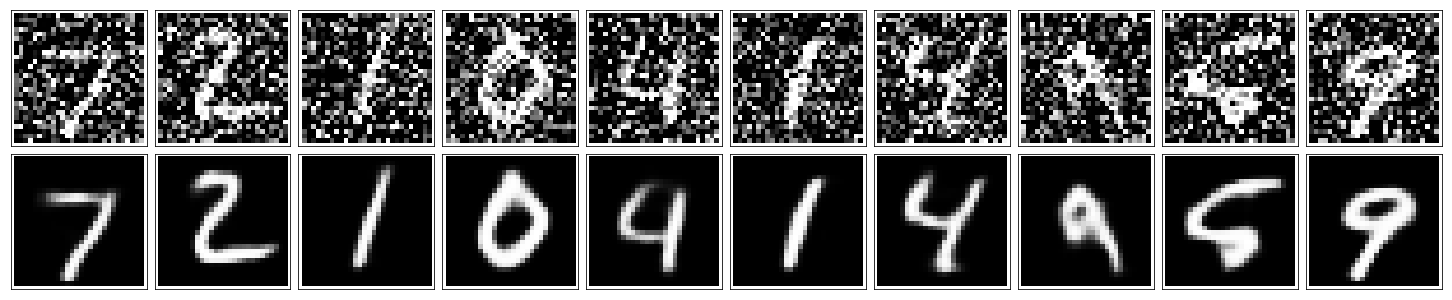

In [20]:
modelRunner.run_autoencoder(denoisingAutoencoder,
                            mnist,
                            image_shape,
                            epochs,
                            batch_size,
                            True,
                            True,
                            noise_factor)